<table>
  <tr><td>
    <img src="h3.png">
  </td></tr>
<table>

# Latar Belakang Project

Pemberlakuaan PPKM Level 4 di beberapa wilayah saat ini merupakan upaya pemerintah untuk menurunkan angka penularan Covid-19 di Indonesia. Meskipun demikian, kebijakan ini menuai pro dan kontra dari masyarakat. Projek ini berisi bagaimana menggali sentimen dari artikel-artikel yang diambil dari situs berita `detik.com` mulai dari awal yaitu scrapping hingga pelabelan sentimen menggunakan metode Lexicon Based. 

# Masalah yang Bisa dijawab

Bagaimana sentimen masyarakat tentang kebijakan PPKM yang diterapkan oleh pemerintah RI?

# Tahap-tahap Sentimen Analysis PPKM 
 
1. Mengambil data artikel (scrapping) dari halaman-halaman situs `detik.com`
2. Melakukan Data Cleaning
3. Melakukan Labeling Menggunakan Metode Lexicon Based
4. Melakukan Analisis Sentimen

# Mengambil Data dari `detik.com`

## Intsalasi Package

Menginstal `package` yang diperlukan yaitu `requests` untuk mengakses alamat url dan `beautifulsoup4` melakukan scrapping halaman web

In [1]:
#instalasi
!pip3 install requests
!pip3 install beautifulsoup4

## Impor Library

In [38]:
import requests
import json
import os
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

Menentukan `keyword` untuk scrapping di situs `detik.com` . Pada projek ini kata kunci yang digunakan adalah **ppkm**

In [3]:
# Target Alamat Web dan kata kunci pencarian[PPKM]
url_web={"detik":"https://www.detik.com/search/searchall?query=ppkm&siteid=2&sortby=time&page="}

Melakukan crawling link berita pada halaman pencarian di situs `detik.com` dan menyimpannya dalam json file.

In [ ]:
#list link berita detik

list_link_detik = []
for i in range(100): # Jumlah Halaman yang di ambil
    URL = url_web['detik']+str(i)
    print(i,'/',100,' - ',URL)
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    results = soup.find_all('article')
    for res in results:
        href_elem = res.find('a')['href']
        list_link_detik.append(href_elem)

len(list_link_detik)


# Simpan dalam bentuk json
with open('list_link_detik_baru.json', 'w', encoding='utf8') as outfile:
    json.dump(list_link_detik, outfile, ensure_ascii=False)
print("tokenized_sent json saved! ")

Membangun fungsi untuk megambil data pada setiap link yang diperoleh

In [4]:
bulan=["Jan","Feb","Mar","Apr","Mei","Jun","Jul","Agu","Sep","Okt","Nov","Des"]

#function get isi berita
def get_data(link):
    isi_berita={}
    page = requests.get(link)
    soup = BeautifulSoup(page.content, 'html.parser')


    results = soup.find(class_="column-8")
    article = results.find("article")

    judul = article.find(class_="detail__title")
    tanggal = article.find(class_="detail__date")
    penulis = article.find(class_="detail__author")
  
    if article.find("img"):
        link_gambar = article.find("img")['src']
    else:
        link_gambar=""

    text_body = article.find(class_="detail__body-text itp_bodycontent")
    lokasi = text_body.find("strong")

    for data in text_body(['style', 'script']): 
        data.decompose()

    text_berita =  ' '.join(text_body.stripped_strings)

    isi_berita['judul'] = judul.text.strip()
    isi_berita['tanggal'] = tanggal.text
    isi_berita['penulis'] = penulis.text
    isi_berita['link_gambar'] = link_gambar
    isi_berita['lokasi'] = lokasi.text
    isi_berita['isi_berita'] = text_berita
    isi_berita['link_lengkap'] = link

    tanggal = re.sub(' +', ' ',tanggal.text.strip())
    tanggal = tanggal.split(" ")
    label_tanggal=tanggal[1]+'-'+str(bulan.index(tanggal[2]))+'-'+tanggal[3]+'-'+tanggal[0].replace(",","")
    nama_file = label_tanggal+' '+str(link.split('/')[-1:][0])+'.json'

    return isi_berita, nama_file

Uji coba scrapping pada link tunggal

In [ ]:
link = 'https://news.detik.com/berita/d-5653909/polisi-siap-terima-aspirasi-massa-diimbau-tak-turun-aksi-tolak-ppkm'
isi_, nama_ = get_data(link)
print(isi_)
print(nama_)

In [5]:
#crawler berita berdasarkan list link berita
fileloc = 'list_link_detik_covid.json'
f = open(fileloc, encoding='utf8')
data = json.load(f)

In [6]:
data1=data[:2000]
data2=data[2000:4000]
data3=data[4000:6000]
data4=data[6000:8000]
data5=data[8000:]

Melakukan crawling pada semua link yang telah dikumpulkan dan menyimpannya dalam beberapa list yaitu:
1. `list tanggal` : list yang menyimpan tanggal dan waktu artikel terbit
2. `list penulis` : list yang menyimpan nama penulis artikel
3. `list judul` : list yang menyimpan =judul artikel
4. `list isi berita` : list yang menyimpan isi berita
5. `list lokasi` : list yang menyimpan  lokasi penerbitan artikel
6. `list link berita` : list yang menyimpan link berita

In [ ]:
tanggal=[]
penulis=[]
judul=[]
list_isi_berita=[]
lokasi=[]
link_berita=[]

for idx, link in enumerate(data1):
    print(idx)
    try:
        isi_berita, nama_file = get_data(link)
        if os.path.isfile(nama_file):
            print("--- sudah ", idx,"/",len(data1))
        else:
            print("--- bisa disimpan", idx,"/",len(data1))
            tanggal.append(isi_berita['tanggal'])
            penulis.append(isi_berita['penulis'])
            judul.append(isi_berita['judul'])
            list_isi_berita.append(isi_berita['isi_berita'])
            lokasi.append(isi_berita['lokasi'])
            link_berita.append(isi_berita['link_lengkap'])
    except Exception as e:
        print("--- gagal",e ,idx,"/",len(data),"",link)

In [ ]:
# Membuat Dictionary Hasil Scrapping
dict_simpan = {'tanggal': tanggal, 
               'penulis': penulis,
               'judul': judul,
               'isi berita':list_isi_berita,
               'lokasi':lokasi,
               'link berita':link_berita} 
# Membuat Dataframe Hasil Scrapping    
df = pd.DataFrame(dict_simpan)
# Menyimpan dalam bentuk csv
df.to_csv('artikel_covid_detik1.csv')

In [7]:
tanggal=[]
penulis=[]
judul=[]
list_isi_berita=[]
lokasi=[]
link_berita=[]

for idx, link in enumerate(data2):
    print(idx)
    try:
        isi_berita, nama_file = get_data(link)
        if os.path.isfile(nama_file):
            print("--- sudah ", idx,"/",len(data2))
        else:
            print("--- bisa disimpan", idx,"/",len(data2))
            tanggal.append(isi_berita['tanggal'])
            penulis.append(isi_berita['penulis'])
            judul.append(isi_berita['judul'])
            list_isi_berita.append(isi_berita['isi_berita'])
            lokasi.append(isi_berita['lokasi'])
            link_berita.append(isi_berita['link_lengkap'])
    except Exception as e:
        print("--- gagal",e ,idx,"/",len(data),"",link)

0
--- bisa disimpan 0 / 2000
1
--- gagal 'NoneType' object has no attribute 'find' 1 / 9000  https://health.detik.com/berita-detikhealth/d-5657975/7-fakta-pencarian-asal-usul-virus-corona-yang-selalu-bikin-penasaran
2
--- bisa disimpan 2 / 2000
3
--- gagal 'NoneType' object has no attribute 'find' 3 / 9000  https://health.detik.com/berita-detikhealth/d-5657970/rekor-40374-sembuh-covid-19-ri-urutan-kedua-di-dunia
4
--- gagal 'NoneType' object has no attribute 'find' 4 / 9000  https://travel.detik.com/travel-news/d-5657933/28-hotel-di-bali-ancang-ancang-jadi-tempat-karantina-traveler-dari-luar-negeri-cek
5
--- gagal 'NoneType' object has no attribute 'find' 5 / 9000  https://food.detik.com/info-sehat/d-5657723/7-makanan-untuk-menyehatkan-paru-paru-dan-saluran-pernafasan
6
--- bisa disimpan 6 / 2000
7
--- gagal 'NoneType' object has no attribute 'find' 7 / 9000  https://health.detik.com/berita-detikhealth/d-5657966/menkes-bakal-coret-oseltamivir-untuk-covid-19-gara-gara-varian-delta
8
---

--- gagal 'NoneType' object has no attribute 'find' 96 / 9000  https://health.detik.com/berita-detikhealth/d-5657612/corona-melonjak-di-as-salah-langkah-tangani-covid-19
97
--- bisa disimpan 97 / 2000
98
--- bisa disimpan 98 / 2000
99
--- gagal 'NoneType' object has no attribute 'find' 99 / 9000  https://inet.detik.com/telecommunication/d-5657557/telkomsel-lanjutkan-pemerataan-jaringan-4glte-hingga-pelosok
100
--- gagal 'NoneType' object has no attribute 'find' 100 / 9000  https://health.detik.com/detiktv/d-5657586/45-juta-vaksin-datang-bulan-agustus-di-antaranya-astrazeneca-pfizer
101
--- bisa disimpan 101 / 2000
102
--- bisa disimpan 102 / 2000
103
--- bisa disimpan 103 / 2000
104
--- bisa disimpan 104 / 2000
105
--- bisa disimpan 105 / 2000
106
--- bisa disimpan 106 / 2000
107
--- bisa disimpan 107 / 2000
108
--- bisa disimpan 108 / 2000
109
--- bisa disimpan 109 / 2000
110
--- bisa disimpan 110 / 2000
111
--- gagal 'NoneType' object has no attribute 'find' 111 / 9000  https://healt

--- bisa disimpan 223 / 2000
224
--- bisa disimpan 224 / 2000
225
--- bisa disimpan 225 / 2000
226
--- bisa disimpan 226 / 2000
227
--- bisa disimpan 227 / 2000
228
--- gagal 'NoneType' object has no attribute 'find' 228 / 9000  https://news.detik.com/detiktv/d-5657204/cegah-penimbunan-erick-thohir-perketat-distribusi-obat-terapi-covid-19
229
--- bisa disimpan 229 / 2000
230
--- bisa disimpan 230 / 2000
231
--- bisa disimpan 231 / 2000
232
--- bisa disimpan 232 / 2000
233
--- bisa disimpan 233 / 2000
234
--- bisa disimpan 234 / 2000
235
--- bisa disimpan 235 / 2000
236
--- gagal 'NoneType' object has no attribute 'find' 236 / 9000  https://health.detik.com/berita-detikhealth/d-5657192/ri-akan-impor-gammaraas-actemra-obat-covid-19-yang-mahalnya-minta-ampun
237
--- bisa disimpan 237 / 2000
238
--- bisa disimpan 238 / 2000
239
--- bisa disimpan 239 / 2000
240
--- bisa disimpan 240 / 2000
241
--- bisa disimpan 241 / 2000
242
--- bisa disimpan 242 / 2000
243
--- bisa disimpan 243 / 2000
244

--- gagal 'NoneType' object has no attribute 'find' 356 / 9000  https://travel.detik.com/travel-news/d-5656751/biksu-thailand-dan-antrean-kremasi-yang-tak-berhenti
357
--- gagal 'NoneType' object has no attribute 'find' 357 / 9000  https://health.detik.com/berita-detikhealth/d-5656750/yuk-vaksin-cdc-99-persen-kematian-dialami-orang-yang-belum-vaksin-corona
358
--- bisa disimpan 358 / 2000
359
--- bisa disimpan 359 / 2000
360
--- bisa disimpan 360 / 2000
361
--- gagal 'NoneType' object has no attribute 'find' 361 / 9000  https://travel.detik.com/travel-news/d-5656714/catat-ya-ini-syarat-perjalanan-ka-jarak-jauh-dan-ka-lokal-mulai-26-juli
362
--- bisa disimpan 362 / 2000
363
--- bisa disimpan 363 / 2000
364
--- bisa disimpan 364 / 2000
365
--- bisa disimpan 365 / 2000
366
--- gagal 'NoneType' object has no attribute 'find' 366 / 9000  https://health.detik.com/berita-detikhealth/d-5656697/makan-di-warung-maksimal-20-menit-santai-ini-risikonya-kalau-buru-buru
367
--- bisa disimpan 367 / 20

--- gagal 'NoneType' object has no attribute 'find' 447 / 9000  https://news.detik.com/detiktv/d-5656479/kadin-ungkap-ada-kendala-stok-vaksin-untuk-program-gotong-royong
448
--- bisa disimpan 448 / 2000
449
--- bisa disimpan 449 / 2000
450
--- gagal 'NoneType' object has no attribute 'find' 450 / 9000  https://news.detik.com/detiktv/d-5656472/pemerintah-beri-bansos-baru-untuk-warga-terdampak-ppkm-level-4
451
--- bisa disimpan 451 / 2000
452
--- bisa disimpan 452 / 2000
453
--- gagal 'NoneType' object has no attribute 'find' 453 / 9000  https://hot.detik.com/detiktv/d-5656485/ibunda-amanda-manopo-meninggal-dunia-karena-covid-19-disertai-komorbid
454
--- bisa disimpan 454 / 2000
455
--- bisa disimpan 455 / 2000
456
--- bisa disimpan 456 / 2000
457
--- bisa disimpan 457 / 2000
458
--- bisa disimpan 458 / 2000
459
--- bisa disimpan 459 / 2000
460
--- bisa disimpan 460 / 2000
461
--- gagal 'NoneType' object has no attribute 'find' 461 / 9000  https://news.detik.com/detiktv/d-5656435/keren-p

--- bisa disimpan 550 / 2000
551
--- bisa disimpan 551 / 2000
552
--- bisa disimpan 552 / 2000
553
--- bisa disimpan 553 / 2000
554
--- bisa disimpan 554 / 2000
555
--- gagal 'NoneType' object has no attribute 'find' 555 / 9000  https://health.detik.com/berita-detikhealth/d-5656152/update-corona-ri-25-juli-tambah-38679-kasus-baru-sembuh-37640
556
--- bisa disimpan 556 / 2000
557
--- gagal 'NoneType' object has no attribute 'find' 557 / 9000  https://travel.detik.com/travel-news/d-5656138/ada-ppkm-pelaku-wisata-kedung-pedut-pilih-jadi-relawan-covid-19
558
--- bisa disimpan 558 / 2000
559
--- gagal 'NoneType' object has no attribute 'find' 559 / 9000  https://news.detik.com/detiktv/d-5656136/kemenkes-sebut-94-kematian-covid-19-karena-belum-vaksinasi
560
--- bisa disimpan 560 / 2000
561
--- bisa disimpan 561 / 2000
562
--- bisa disimpan 562 / 2000
563
--- gagal 'NoneType' object has no attribute 'find' 563 / 9000  https://health.detik.com/detiktv/d-5656120/penjelasan-pakar-soal-booster-va

--- gagal 'NoneType' object has no attribute 'find' 671 / 9000  https://food.detik.com/berita-boga/d-5655461/saat-pandemi-penjualan-jahe-seduh-borobudur-naik-dua-kali-lipat
672
--- bisa disimpan 672 / 2000
673
--- bisa disimpan 673 / 2000
674
--- bisa disimpan 674 / 2000
675
--- gagal 'NoneType' object has no attribute 'find' 675 / 9000  https://health.detik.com/berita-detikhealth/d-5655795/ramai-isu-covid-19-buatan-lab-wuhan-bantah-rancang-dan-bocorkan-corona
676
--- gagal 'NoneType' object has no attribute 'find' 676 / 9000  https://health.detik.com/detiktv/d-5655793/pentingnya-asupan-protein-di-masa-pandemi-covid-19
677
--- bisa disimpan 677 / 2000
678
--- gagal 'NoneType' object has no attribute 'find' 678 / 9000  https://food.detik.com/berita-boga/d-5655754/bakso-enak-di-depok-dan-racikan-rahasia-mie-instan-warkop
679
--- bisa disimpan 679 / 2000
680
--- gagal 'NoneType' object has no attribute 'find' 680 / 9000  https://travel.detik.com/travel-news/d-5655787/bukan-cuma-garut-peng

--- bisa disimpan 784 / 2000
785
--- bisa disimpan 785 / 2000
786
--- gagal 'NoneType' object has no attribute 'find' 786 / 9000  https://health.detik.com/berita-detikhealth/d-5655410/cara-cek-dan-download-sertifikat-vaksin-di-pedulilindungiid-simak-di-sini
787
--- gagal 'NoneType' object has no attribute 'find' 787 / 9000  https://health.detik.com/detiktv/d-5655397/cara-kerja-vaksin-covid-19-di-tubuh-anak-anak-dan-orang-dewasa
788
--- bisa disimpan 788 / 2000
789
--- gagal 'NoneType' object has no attribute 'find' 789 / 9000  https://inet.detik.com/science/d-5655375/uji-fase-ii-sinovac-diklaim-988-efektif-untuk-anak-kecil
790
--- bisa disimpan 790 / 2000
791
--- bisa disimpan 791 / 2000
792
--- bisa disimpan 792 / 2000
793
--- bisa disimpan 793 / 2000
794
--- gagal 'NoneType' object has no attribute 'find' 794 / 9000  https://travel.detik.com/travel-news/d-5655315/dihantam-corona-ppkm-darurat-kawasan-wisata-lembang-mati-suri
795
--- bisa disimpan 795 / 2000
796
--- bisa disimpan 796 /

--- bisa disimpan 913 / 2000
914
--- bisa disimpan 914 / 2000
915
--- bisa disimpan 915 / 2000
916
--- bisa disimpan 916 / 2000
917
--- bisa disimpan 917 / 2000
918
--- bisa disimpan 918 / 2000
919
--- bisa disimpan 919 / 2000
920
--- bisa disimpan 920 / 2000
921
--- gagal 'NoneType' object has no attribute 'find' 921 / 9000  https://travel.detik.com/travel-news/d-5654941/travel-bubble-new-zealand-australia-disetop
922
--- gagal 'NoneType' object has no attribute 'find' 922 / 9000  https://health.detik.com/berita-detikhealth/d-5654932/tak-semua-pasien-covid-19-bisa-isoman-kapan-harus-ke-rs
923
--- bisa disimpan 923 / 2000
924
--- bisa disimpan 924 / 2000
925
--- gagal 'NoneType' object has no attribute 'find' 925 / 9000  https://wolipop.detik.com/health-and-diet/d-5654719/bolehkah-suntik-vaksin-covid-19-saat-haid-ini-penjelasan-dari-dokter
926
--- bisa disimpan 926 / 2000
927
--- bisa disimpan 927 / 2000
928
--- bisa disimpan 928 / 2000
929
--- bisa disimpan 929 / 2000
930
--- bisa dis

--- bisa disimpan 1020 / 2000
1021
--- gagal 'NoneType' object has no attribute 'find' 1021 / 9000  https://travel.detik.com/travel-news/d-5654643/sandiaga-jangan-sampai-lebih-banyak-bendera-putih-dikibarkan
1022
--- gagal 'NoneType' object has no attribute 'find' 1022 / 9000  https://inet.detik.com/cyberlife/d-5654461/pengamat-ke-pemerintah-e-ktp-modern-gak-perlu-fotokopi
1023
--- bisa disimpan 1023 / 2000
1024
--- gagal 'NoneType' object has no attribute 'find' 1024 / 9000  https://health.detik.com/berita-detikhealth/d-5654666/viral-jokowi-cari-oseltamivir-dan-favipiravir-di-apotek-obat-apa-sih
1025
--- bisa disimpan 1025 / 2000
1026
--- gagal 'NoneType' object has no attribute 'find' 1026 / 9000  https://news.detik.com/detiktv/d-5654664/ada-anak-bertanya-kenapa-tak-lockdown-jubir-covid-19-menjawab
1027
--- bisa disimpan 1027 / 2000
1028
--- bisa disimpan 1028 / 2000
1029
--- bisa disimpan 1029 / 2000
1030
--- gagal 'NoneType' object has no attribute 'find' 1030 / 9000  https://healt

--- bisa disimpan 1124 / 2000
1125
--- bisa disimpan 1125 / 2000
1126
--- bisa disimpan 1126 / 2000
1127
--- gagal 'NoneType' object has no attribute 'find' 1127 / 9000  https://inet.detik.com/cyberlife/d-5653865/viral-fotokopi-e-ktp-persulit-vaksinasi-pengamat-padahal-e-itu-elektronik
1128
--- bisa disimpan 1128 / 2000
1129
--- bisa disimpan 1129 / 2000
1130
--- bisa disimpan 1130 / 2000
1131
--- bisa disimpan 1131 / 2000
1132
--- bisa disimpan 1132 / 2000
1133
--- bisa disimpan 1133 / 2000
1134
--- bisa disimpan 1134 / 2000
1135
--- bisa disimpan 1135 / 2000
1136
--- bisa disimpan 1136 / 2000
1137
--- bisa disimpan 1137 / 2000
1138
--- bisa disimpan 1138 / 2000
1139
--- bisa disimpan 1139 / 2000
1140
--- bisa disimpan 1140 / 2000
1141
--- gagal 'NoneType' object has no attribute 'find' 1141 / 9000  https://travel.detik.com/travel-news/d-5654079/penumpang-cuma-dikit-maskapai-ramai-ramai-batal-terbang
1142
--- bisa disimpan 1142 / 2000
1143
--- bisa disimpan 1143 / 2000
1144
--- bisa d

--- gagal 'NoneType' object has no attribute 'find' 1234 / 9000  https://food.detik.com/info-sehat/d-5653140/gegara-ikut-tren-hidup-sehat-pria-termalas-ini-turun-bb-30-kilogram
1235
--- gagal 'NoneType' object has no attribute 'find' 1235 / 9000  https://health.detik.com/berita-detikhealth/d-5653819/bekasi-12-ribu-kab-kota-ini-juara-kasus-covid-19-sepekan-terakhir-di-jabar
1236
--- bisa disimpan 1236 / 2000
1237
--- bisa disimpan 1237 / 2000
1238
--- bisa disimpan 1238 / 2000
1239
--- bisa disimpan 1239 / 2000
1240
--- gagal 'NoneType' object has no attribute 'find' 1240 / 9000  https://travel.detik.com/travel-news/d-5653800/di-australia-drone-dipakai-buat-antar-rokok-ke-hotel-karantina
1241
--- gagal 'NoneType' object has no attribute 'find' 1241 / 9000  https://health.detik.com/berita-detikhealth/d-5653793/corona-melonjak-ribuan-dokter-muda-di-malaysia-berencana-mogok-kerja
1242
--- gagal 'NoneType' object has no attribute 'find' 1242 / 9000  https://health.detik.com/detiktv/d-565392

--- bisa disimpan 1345 / 2000
1346
--- gagal 'NoneType' object has no attribute 'find' 1346 / 9000  https://travel.detik.com/travel-news/d-5653314/kejadian-selip-lidah-petugas-atc-nyaris-berbuntut-petaka
1347
--- bisa disimpan 1347 / 2000
1348
--- bisa disimpan 1348 / 2000
1349
--- gagal 'NoneType' object has no attribute 'find' 1349 / 9000  https://wolipop.detik.com/worklife/d-5653080/inspiratif-cerita-anak-tukang-cuci-yang-sukses-buka-usaha-laundry
1350
--- gagal 'NoneType' object has no attribute 'find' 1350 / 9000  https://health.detik.com/berita-detikhealth/d-5653363/satgas-ingatkan-ada-kerabat-kolega-dalam-rekor-1449-kematian-covid-19
1351
--- bisa disimpan 1351 / 2000
1352
--- gagal 'NoneType' object has no attribute 'find' 1352 / 9000  https://inet.detik.com/science/d-5653262/lab-wuhan-kembali-bantah-keras-bocorkan-virus-corona
1353
--- gagal 'NoneType' object has no attribute 'find' 1353 / 9000  https://health.detik.com/berita-detikhealth/d-5653360/paket-obat-gratis-susah-dida

--- bisa disimpan 1442 / 2000
1443
--- bisa disimpan 1443 / 2000
1444
--- bisa disimpan 1444 / 2000
1445
--- bisa disimpan 1445 / 2000
1446
--- bisa disimpan 1446 / 2000
1447
--- bisa disimpan 1447 / 2000
1448
--- bisa disimpan 1448 / 2000
1449
--- bisa disimpan 1449 / 2000
1450
--- gagal 'NoneType' object has no attribute 'find' 1450 / 9000  https://travel.detik.com/travel-news/d-5653026/buka-lapangan-kerja-sandiaga-ajak-diaspora-promosikan-dangdut-di-as
1451
--- bisa disimpan 1451 / 2000
1452
--- bisa disimpan 1452 / 2000
1453
--- bisa disimpan 1453 / 2000
1454
--- bisa disimpan 1454 / 2000
1455
--- gagal 'NoneType' object has no attribute 'find' 1455 / 9000  https://health.detik.com/berita-detikhealth/d-5652989/4-negara-yang-kembali-diamuk-covid-19-usai-sempat-sukses-atasi-corona
1456
--- gagal 'NoneType' object has no attribute 'find' 1456 / 9000  https://wolipop.detik.com/entertainment-news/d-5652896/cerita-aktor-jadi-sukarelawan-urus-jenazah-covid-19-alami-hal-mistis-ini
1457
---

--- bisa disimpan 1553 / 2000
1554
--- bisa disimpan 1554 / 2000
1555
--- bisa disimpan 1555 / 2000
1556
--- bisa disimpan 1556 / 2000
1557
--- gagal 'NoneType' object has no attribute 'find' 1557 / 9000  https://news.detik.com/detiktv/d-5652655/istilah-ppkm-berganti-ganti-pimpinan-komisi-ix-bentuk-inkonsistensi
1558
--- gagal 'NoneType' object has no attribute 'find' 1558 / 9000  https://travel.detik.com/travel-news/d-5652653/arab-saudi-larang-warganya-datang-ke-indonesia
1559
--- bisa disimpan 1559 / 2000
1560
--- gagal 'NoneType' object has no attribute 'find' 1560 / 9000  https://health.detik.com/berita-detikhealth/d-5652646/cacar-monyet-gemparkan-as-ini-bedanya-dengan-virus-monkey-b-di-china
1561
--- bisa disimpan 1561 / 2000
1562
--- bisa disimpan 1562 / 2000
1563
--- gagal 'NoneType' object has no attribute 'find' 1563 / 9000  https://news.detik.com/detiktv/d-5652635/epidemiolog-minta-masyarakat-tak-berekspektasi-ivermectin-obat-covid-19
1564
--- gagal 'NoneType' object has no a

--- bisa disimpan 1664 / 2000
1665
--- bisa disimpan 1665 / 2000
1666
--- bisa disimpan 1666 / 2000
1667
--- bisa disimpan 1667 / 2000
1668
--- bisa disimpan 1668 / 2000
1669
--- bisa disimpan 1669 / 2000
1670
--- gagal 'NoneType' object has no attribute 'find' 1670 / 9000  https://wolipop.detik.com/travel/d-5652271/perlu-tahu-ini-keuntungan-beli-tiket-pesawat-online-saat-pandemi
1671
--- gagal 'NoneType' object has no attribute 'find' 1671 / 9000  https://health.detik.com/berita-detikhealth/d-5652270/varian-delta-disebut-bisa-menular-dengan-amat-cepat-siapa-paling-rentan-kena
1672
--- gagal 'NoneType' object has no attribute 'find' 1672 / 9000  https://travel.detik.com/travel-news/d-5652267/pembatasan-krl-jabodetabek-masih-berlaku-di-perpanjangan-ppkm
1673
--- bisa disimpan 1673 / 2000
1674
--- bisa disimpan 1674 / 2000
1675
--- bisa disimpan 1675 / 2000
1676
--- bisa disimpan 1676 / 2000
1677
--- gagal 'NoneType' object has no attribute 'find' 1677 / 9000  https://news.detik.com/deti

--- bisa disimpan 1766 / 2000
1767
--- bisa disimpan 1767 / 2000
1768
--- bisa disimpan 1768 / 2000
1769
--- bisa disimpan 1769 / 2000
1770
--- bisa disimpan 1770 / 2000
1771
--- bisa disimpan 1771 / 2000
1772
--- gagal 'NoneType' object has no attribute 'find' 1772 / 9000  https://news.detik.com/detiktv/d-5651964/singapura-lockdown-parsial-sebulan-pertemuan-maksimal-2-orang
1773
--- bisa disimpan 1773 / 2000
1774
--- bisa disimpan 1774 / 2000
1775
--- gagal 'NoneType' object has no attribute 'find' 1775 / 9000  https://travel.detik.com/travel-news/d-5651817/jetstar-jadi-maskapai-budget-terbaik-di-asia-pasifik-2021
1776
--- bisa disimpan 1776 / 2000
1777
--- bisa disimpan 1777 / 2000
1778
--- bisa disimpan 1778 / 2000
1779
--- bisa disimpan 1779 / 2000
1780
--- bisa disimpan 1780 / 2000
1781
--- bisa disimpan 1781 / 2000
1782
--- gagal 'NoneType' object has no attribute 'find' 1782 / 9000  https://health.detik.com/berita-detikhealth/d-5651921/kudus-kekurangan-stok-vaksin-sinovac-butuh-

--- bisa disimpan 1900 / 2000
1901
--- bisa disimpan 1901 / 2000
1902
--- bisa disimpan 1902 / 2000
1903
--- bisa disimpan 1903 / 2000
1904
--- bisa disimpan 1904 / 2000
1905
--- bisa disimpan 1905 / 2000
1906
--- bisa disimpan 1906 / 2000
1907
--- bisa disimpan 1907 / 2000
1908
--- gagal 'NoneType' object has no attribute 'find' 1908 / 9000  https://health.detik.com/berita-detikhealth/d-5651470/apresiasi-dr-reisa-untuk-indra-rudiansyah-ilmuwan-vaksin-astrazeneca-asal-ri
1909
--- bisa disimpan 1909 / 2000
1910
--- bisa disimpan 1910 / 2000
1911
--- bisa disimpan 1911 / 2000
1912
--- bisa disimpan 1912 / 2000
1913
--- gagal 'NoneType' object has no attribute 'find' 1913 / 9000  https://travel.detik.com/travel-news/d-5651463/selain-ranjang-antiseks-atlet-olimpiade-tokyo-juga-dapat-kondom-gratis
1914
--- bisa disimpan 1914 / 2000
1915
--- bisa disimpan 1915 / 2000
1916
--- gagal 'NoneType' object has no attribute 'find' 1916 / 9000  https://food.detik.com/resep-praktis/d-5651406/3-resep-k

In [8]:
# Membuat Dictionary Hasil Scrapping
dict_simpan = {'tanggal': tanggal, 
               'penulis': penulis,
               'judul': judul,
               'isi berita':list_isi_berita,
               'lokasi':lokasi,
               'link berita':link_berita} 
# Membuat Dataframe Hasil Scrapping    
df = pd.DataFrame(dict_simpan)
# Menyimpan dalam bentuk csv
df.to_csv('artikel_covid_detik2.csv')

In [9]:
tanggal=[]
penulis=[]
judul=[]
list_isi_berita=[]
lokasi=[]
link_berita=[]

for idx, link in enumerate(data3):
    print(idx)
    try:
        isi_berita, nama_file = get_data(link)
        if os.path.isfile(nama_file):
            print("--- sudah ", idx,"/",len(data3))
        else:
            print("--- bisa disimpan", idx,"/",len(data3))
            tanggal.append(isi_berita['tanggal'])
            penulis.append(isi_berita['penulis'])
            judul.append(isi_berita['judul'])
            list_isi_berita.append(isi_berita['isi_berita'])
            lokasi.append(isi_berita['lokasi'])
            link_berita.append(isi_berita['link_lengkap'])
    except Exception as e:
        print("--- gagal",e ,idx,"/",len(data),"",link)

0
--- gagal 'NoneType' object has no attribute 'find' 0 / 9000  https://travel.detik.com/travel-news/d-5651113/ppkm-diperpanjang-hotel-non-penanganan-karantina-beroperasi-50-persen
1
--- bisa disimpan 1 / 2000
2
--- bisa disimpan 2 / 2000
3
--- bisa disimpan 3 / 2000
4
--- gagal 'NoneType' object has no attribute 'find' 4 / 9000  https://health.detik.com/berita-detikhealth/d-5651093/izin-bpom-untuk-ivermectin-soal-covid-19-adalah-eap-ini-bedanya-dengan-eua
5
--- gagal 'NoneType' object has no attribute 'find' 5 / 9000  https://news.detik.com/detiktv/d-5651088/40-juta-warga-brasil-diprediksi-hidup-miskin-akibat-pandemi-covid-19
6
--- bisa disimpan 6 / 2000
7
--- bisa disimpan 7 / 2000
8
--- gagal 'NoneType' object has no attribute 'find' 8 / 9000  https://news.detik.com/detiktv/d-5651083/oksigen-langka-14-pasien-covid-19-di-rsu-holistik-meninggal-dunia
9
--- bisa disimpan 9 / 2000
10
--- bisa disimpan 10 / 2000
11
--- bisa disimpan 11 / 2000
12
--- gagal 'NoneType' object has no attribu

--- bisa disimpan 119 / 2000
120
--- bisa disimpan 120 / 2000
121
--- bisa disimpan 121 / 2000
122
--- gagal 'NoneType' object has no attribute 'find' 122 / 9000  https://news.detik.com/detiktv/d-5650687/blak-blakan-wapres-maruf-amin-silent-bukan-berarti-tak-kerja
123
--- bisa disimpan 123 / 2000
124
--- bisa disimpan 124 / 2000
125
--- gagal 'NoneType' object has no attribute 'find' 125 / 9000  https://health.detik.com/berita-detikhealth/d-5650681/istilah-baru-ppkm-level-3-4-berlaku-di-jawa-bali-artinya-apa-sih
126
--- bisa disimpan 126 / 2000
127
--- bisa disimpan 127 / 2000
128
--- gagal 'NoneType' object has no attribute 'find' 128 / 9000  https://travel.detik.com/travel-news/d-5650533/anjlok-okupansi-hotel-cuma-10-persen-pas-ppkm-darurat
129
--- gagal 'NoneType' object has no attribute 'find' 129 / 9000  https://news.detik.com/detiktv/d-5650663/krisis-oksigen-medis-tunisia-minta-tolong-negara-sahabat
130
--- bisa disimpan 130 / 2000
131
--- gagal 'NoneType' object has no attribute

--- bisa disimpan 232 / 2000
233
--- bisa disimpan 233 / 2000
234
--- gagal 'NoneType' object has no attribute 'find' 234 / 9000  https://health.detik.com/detiktv/d-5650343/daftar-sebaran-varian-covid-19-di-indonesia
235
--- bisa disimpan 235 / 2000
236
--- bisa disimpan 236 / 2000
237
--- bisa disimpan 237 / 2000
238
--- bisa disimpan 238 / 2000
239
--- bisa disimpan 239 / 2000
240
--- bisa disimpan 240 / 2000
241
--- bisa disimpan 241 / 2000
242
--- bisa disimpan 242 / 2000
243
--- gagal 'NoneType' object has no attribute 'find' 243 / 9000  https://health.detik.com/berita-detikhealth/d-5650297/efikasi-moderna-tinggi-jatah-siapa-lagi-setelah-nakes-ini-kata-menkes
244
--- gagal 'NoneType' object has no attribute 'find' 244 / 9000  https://food.detik.com/info-kuliner/d-5648687/satpol-pp-kota-bogor-sidak-pedagang-sambil-bagi-bagi-makanan
245
--- bisa disimpan 245 / 2000
246
--- bisa disimpan 246 / 2000
247
--- bisa disimpan 247 / 2000
248
--- bisa disimpan 248 / 2000
249
--- bisa disimpa

--- bisa disimpan 353 / 2000
354
--- bisa disimpan 354 / 2000
355
--- bisa disimpan 355 / 2000
356
--- bisa disimpan 356 / 2000
357
--- bisa disimpan 357 / 2000
358
--- bisa disimpan 358 / 2000
359
--- bisa disimpan 359 / 2000
360
--- bisa disimpan 360 / 2000
361
--- bisa disimpan 361 / 2000
362
--- bisa disimpan 362 / 2000
363
--- bisa disimpan 363 / 2000
364
--- bisa disimpan 364 / 2000
365
--- gagal 'NoneType' object has no attribute 'find' 365 / 9000  https://news.detik.com/detiktv/d-5649695/doa-anies-di-idul-adha-semoga-allah-kuatkan-yang-jihad-lawan-pandemi
366
--- bisa disimpan 366 / 2000
367
--- gagal 'NoneType' object has no attribute 'find' 367 / 9000  https://health.detik.com/berita-detikhealth/d-5649357/panduan-aman-menyusui-bagi-ibu-yang-positif-covid-19
368
--- bisa disimpan 368 / 2000
369
--- bisa disimpan 369 / 2000
370
--- bisa disimpan 370 / 2000
371
--- bisa disimpan 371 / 2000
372
--- bisa disimpan 372 / 2000
373
--- bisa disimpan 373 / 2000
374
--- bisa disimpan 37

--- bisa disimpan 480 / 2000
481
--- gagal 'NoneType' object has no attribute 'find' 481 / 9000  https://news.detik.com/detiktv/d-5649415/walkot-yogya-tak-izinkan-warga-sembelih-hewan-kurban-di-perkampungan
482
--- gagal 'NoneType' object has no attribute 'find' 482 / 9000  https://news.detik.com/detiktv/d-5649482/menparekraf-genjot-vaksinasi-corona-dengan-gandeng-6-ptn-pariwisata
483
--- bisa disimpan 483 / 2000
484
--- bisa disimpan 484 / 2000
485
--- bisa disimpan 485 / 2000
486
--- bisa disimpan 486 / 2000
487
--- gagal 'NoneType' object has no attribute 'find' 487 / 9000  https://health.detik.com/berita-detikhealth/d-5649396/dr-faheem-beberkan-alasan-terapi-plasma-konvalesen-untuk-covid-19-tak-efektif
488
--- bisa disimpan 488 / 2000
489
--- bisa disimpan 489 / 2000
490
--- bisa disimpan 490 / 2000
491
--- bisa disimpan 491 / 2000
492
--- bisa disimpan 492 / 2000
493
--- gagal 'NoneType' object has no attribute 'find' 493 / 9000  https://health.detik.com/berita-detikhealth/d-56493

--- gagal 'NoneType' object has no attribute 'find' 612 / 9000  https://health.detik.com/berita-detikhealth/d-5648890/lanjut-terus-atau-udahan-dr-tirta-sebut-dua-opsi-skenario-ppkm-darurat
613
--- gagal 'NoneType' object has no attribute 'find' 613 / 9000  https://news.detik.com/detiktv/d-5648889/11-juta-dosis-vaksin-sinopharm-mendarat-di-indonesia
614
--- gagal 'NoneType' object has no attribute 'find' 614 / 9000  https://food.detik.com/info-kuliner/d-5648195/unggah-teh-susu-buatan-sang-pacar-netizen-ini-malah-dihujat
615
--- bisa disimpan 615 / 2000
616
--- bisa disimpan 616 / 2000
617
--- bisa disimpan 617 / 2000
618
--- bisa disimpan 618 / 2000
619
--- gagal 'NoneType' object has no attribute 'find' 619 / 9000  https://health.detik.com/berita-detikhealth/d-5648876/pakar-bandingkan-dampak-pandemi-vs-perang-dunia-ii-mana-lebih-traumatis
620
--- bisa disimpan 620 / 2000
621
--- bisa disimpan 621 / 2000
622
--- bisa disimpan 622 / 2000
623
--- bisa disimpan 623 / 2000
624
--- bisa disi

--- bisa disimpan 744 / 2000
745
--- bisa disimpan 745 / 2000
746
--- bisa disimpan 746 / 2000
747
--- bisa disimpan 747 / 2000
748
--- bisa disimpan 748 / 2000
749
--- gagal 'NoneType' object has no attribute 'find' 749 / 9000  https://health.detik.com/berita-detikhealth/d-5648465/ada-100-ribu-lebih-kasus-aktif-corona-di-dki-ini-wilayah-penyumbang-terbanyak
750
--- bisa disimpan 750 / 2000
751
--- bisa disimpan 751 / 2000
752
--- bisa disimpan 752 / 2000
753
--- bisa disimpan 753 / 2000
754
--- bisa disimpan 754 / 2000
755
--- bisa disimpan 755 / 2000
756
--- bisa disimpan 756 / 2000
757
--- bisa disimpan 757 / 2000
758
--- bisa disimpan 758 / 2000
759
--- bisa disimpan 759 / 2000
760
--- gagal 'NoneType' object has no attribute 'find' 760 / 9000  https://health.detik.com/berita-detikhealth/d-5648437/positif-covid-19-butuh-waktu-berapa-lama-untuk-sembuh-ternyata-ini-jawabannya
761
--- bisa disimpan 761 / 2000
762
--- bisa disimpan 762 / 2000
763
--- bisa disimpan 763 / 2000
764
--- ga

--- gagal 'NoneType' object has no attribute 'find' 857 / 9000  https://health.detik.com/sexual-health/d-5648083/ahli-tak-sarankan-seks-usai-vaksin-covid-19-ini-alasannya
858
--- bisa disimpan 858 / 2000
859
--- bisa disimpan 859 / 2000
860
--- bisa disimpan 860 / 2000
861
--- bisa disimpan 861 / 2000
862
--- bisa disimpan 862 / 2000
863
--- bisa disimpan 863 / 2000
864
--- bisa disimpan 864 / 2000
865
--- bisa disimpan 865 / 2000
866
--- bisa disimpan 866 / 2000
867
--- bisa disimpan 867 / 2000
868
--- gagal 'NoneType' object has no attribute 'find' 868 / 9000  https://health.detik.com/berita-detikhealth/d-5648057/rekomendasi-obat-dan-vitamin-untuk-isolasi-mandiri-pasien-corona
869
--- gagal 'NoneType' object has no attribute 'find' 869 / 9000  https://news.detik.com/detiktv/d-5648058/perhatikan-prokes-pemotongan-hewan-kurban-untuk-idul-adha
870
--- gagal 'NoneType' object has no attribute 'find' 870 / 9000  https://wolipop.detik.com/entertainment-news/d-5648010/most-pop-sepekan-reaks

--- bisa disimpan 981 / 2000
982
--- bisa disimpan 982 / 2000
983
--- bisa disimpan 983 / 2000
984
--- bisa disimpan 984 / 2000
985
--- bisa disimpan 985 / 2000
986
--- bisa disimpan 986 / 2000
987
--- gagal 'NoneType' object has no attribute 'find' 987 / 9000  https://health.detik.com/berita-detikhealth/d-5647631/lbh-kesehatan-minta-jokowi-bagikan-ivermectin-ke-masyarakat
988
--- gagal 'NoneType' object has no attribute 'find' 988 / 9000  https://finance.detik.com/detiktv/d-5647638/anggaran-kesehatan-covid-19-naik-jadi-rp-2149-t-berikut-rinciannya
989
--- bisa disimpan 989 / 2000
990
--- bisa disimpan 990 / 2000
991
--- gagal 'NoneType' object has no attribute 'find' 991 / 9000  https://travel.detik.com/travel-news/d-5647598/jawaban-imigrasi-soal-wna-masuk-ri-sampai-munculnya-babirusa-di-maluku
992
--- bisa disimpan 992 / 2000
993
--- gagal 'NoneType' object has no attribute 'find' 993 / 9000  https://news.detik.com/detiktv/d-5647628/blak-blakan-ustaz-m-ujang-bustomi-dukun-santet-dan-

--- gagal 'NoneType' object has no attribute 'find' 1091 / 9000  https://news.detik.com/detiktv/d-5647344/luhut-minta-maaf-jika-penanganan-ppkm-darurat-belum-optimal
1092
--- bisa disimpan 1092 / 2000
1093
--- bisa disimpan 1093 / 2000
1094
--- bisa disimpan 1094 / 2000
1095
--- bisa disimpan 1095 / 2000
1096
--- bisa disimpan 1096 / 2000
1097
--- bisa disimpan 1097 / 2000
1098
--- gagal 'NoneType' object has no attribute 'find' 1098 / 9000  https://travel.detik.com/travel-news/d-5647333/setelah-phuket-thailand-buka-tiga-pulau-lain-untuk-turis-asing
1099
--- bisa disimpan 1099 / 2000
1100
--- bisa disimpan 1100 / 2000
1101
--- bisa disimpan 1101 / 2000
1102
--- bisa disimpan 1102 / 2000
1103
--- bisa disimpan 1103 / 2000
1104
--- bisa disimpan 1104 / 2000
1105
--- bisa disimpan 1105 / 2000
1106
--- bisa disimpan 1106 / 2000
1107
--- bisa disimpan 1107 / 2000
1108
--- gagal 'NoneType' object has no attribute 'find' 1108 / 9000  https://inet.detik.com/science/d-5647078/pm-australia-dunia

--- bisa disimpan 1211 / 2000
1212
--- gagal 'NoneType' object has no attribute 'find' 1212 / 9000  https://news.detik.com/detiktv/d-5646938/aksi-seniman-jaranan-buto-ajak-warga-banyuwangi-vaksin-dan-jaga-prokes
1213
--- bisa disimpan 1213 / 2000
1214
--- bisa disimpan 1214 / 2000
1215
--- bisa disimpan 1215 / 2000
1216
--- bisa disimpan 1216 / 2000
1217
--- bisa disimpan 1217 / 2000
1218
--- bisa disimpan 1218 / 2000
1219
--- bisa disimpan 1219 / 2000
1220
--- bisa disimpan 1220 / 2000
1221
--- bisa disimpan 1221 / 2000
1222
--- bisa disimpan 1222 / 2000
1223
--- gagal 'NoneType' object has no attribute 'find' 1223 / 9000  https://news.detik.com/detiktv/d-5646911/pan-gelar-vaksinasi-covid-19-massal-di-jaksel-siapkan-1300-dosis
1224
--- gagal 'NoneType' object has no attribute 'find' 1224 / 9000  https://travel.detik.com/travel-news/d-5646834/sandiaga-uno-vaksinasi-pelaku-parekraf-indonesia-baru-5-persen
1225
--- bisa disimpan 1225 / 2000
1226
--- bisa disimpan 1226 / 2000
1227
--- bis

--- bisa disimpan 1338 / 2000
1339
--- bisa disimpan 1339 / 2000
1340
--- gagal 'NoneType' object has no attribute 'find' 1340 / 9000  https://health.detik.com/berita-detikhealth/d-5646490/faskes-ri-di-ambang-functional-collapse-dihajar-covid-19
1341
--- bisa disimpan 1341 / 2000
1342
--- bisa disimpan 1342 / 2000
1343
--- bisa disimpan 1343 / 2000
1344
--- gagal 'NoneType' object has no attribute 'find' 1344 / 9000  https://inet.detik.com/cyberlife/d-5646456/jokowi-batalkan-vaksin-berbayar-netizen-bahagia
1345
--- bisa disimpan 1345 / 2000
1346
--- bisa disimpan 1346 / 2000
1347
--- bisa disimpan 1347 / 2000
1348
--- bisa disimpan 1348 / 2000
1349
--- bisa disimpan 1349 / 2000
1350
--- bisa disimpan 1350 / 2000
1351
--- bisa disimpan 1351 / 2000
1352
--- gagal 'NoneType' object has no attribute 'find' 1352 / 9000  https://news.detik.com/detiktv/d-5646470/2000-tempat-tidur-tambahan-disiapkan-untuk-pasien-covid-19
1353
--- bisa disimpan 1353 / 2000
1354
--- bisa disimpan 1354 / 2000
135

--- gagal 'NoneType' object has no attribute 'find' 1462 / 9000  https://food.detik.com/info-kuliner/d-5645497/emak-emak-di-korea-ini-doyan-kangkung-sampai-tanam-dan-masak-sendiri
1463
--- bisa disimpan 1463 / 2000
1464
--- gagal 'NoneType' object has no attribute 'find' 1464 / 9000  https://news.detik.com/detiktv/d-5646099/dki-teratas-berikut-sebaran-54-ribu-kasus-baru-covid-19-ri-16-juli
1465
--- gagal 'NoneType' object has no attribute 'find' 1465 / 9000  https://travel.detik.com/travel-news/d-5646096/2-kerapuhan-australia-penyebab-dan-akibat-meroketnya-corona
1466
--- bisa disimpan 1466 / 2000
1467
--- bisa disimpan 1467 / 2000
1468
--- bisa disimpan 1468 / 2000
1469
--- bisa disimpan 1469 / 2000
1470
--- bisa disimpan 1470 / 2000
1471
--- bisa disimpan 1471 / 2000
1472
--- bisa disimpan 1472 / 2000
1473
--- bisa disimpan 1473 / 2000
1474
--- bisa disimpan 1474 / 2000
1475
--- bisa disimpan 1475 / 2000
1476
--- gagal 'NoneType' object has no attribute 'find' 1476 / 9000  https://he

--- bisa disimpan 1567 / 2000
1568
--- bisa disimpan 1568 / 2000
1569
--- bisa disimpan 1569 / 2000
1570
--- bisa disimpan 1570 / 2000
1571
--- bisa disimpan 1571 / 2000
1572
--- gagal 'NoneType' object has no attribute 'find' 1572 / 9000  https://news.detik.com/detiktv/d-5645780/saat-tni-polri-satpol-pp-bahu-membahu-bikin-peti-jenazah-covid-19
1573
--- bisa disimpan 1573 / 2000
1574
--- bisa disimpan 1574 / 2000
1575
--- bisa disimpan 1575 / 2000
1576
--- bisa disimpan 1576 / 2000
1577
--- bisa disimpan 1577 / 2000
1578
--- gagal 'NoneType' object has no attribute 'find' 1578 / 9000  https://health.detik.com/berita-detikhealth/d-5645762/kepala-uji-klinis-sinovac-di-chili-sarankan-dosis-ketiga-vaksin-covid-19
1579
--- bisa disimpan 1579 / 2000
1580
--- bisa disimpan 1580 / 2000
1581
--- bisa disimpan 1581 / 2000
1582
--- bisa disimpan 1582 / 2000
1583
--- bisa disimpan 1583 / 2000
1584
--- bisa disimpan 1584 / 2000
1585
--- gagal 'NoneType' object has no attribute 'find' 1585 / 9000  h

--- bisa disimpan 1682 / 2000
1683
--- bisa disimpan 1683 / 2000
1684
--- bisa disimpan 1684 / 2000
1685
--- bisa disimpan 1685 / 2000
1686
--- bisa disimpan 1686 / 2000
1687
--- bisa disimpan 1687 / 2000
1688
--- bisa disimpan 1688 / 2000
1689
--- gagal 'NoneType' object has no attribute 'find' 1689 / 9000  https://health.detik.com/berita-detikhealth/d-5645386/corona-ri-rekor-bertubi-tubi-satgas-ungkap-sumber-penularan-terbanyak
1690
--- bisa disimpan 1690 / 2000
1691
--- bisa disimpan 1691 / 2000
1692
--- gagal 'NoneType' object has no attribute 'find' 1692 / 9000  https://travel.detik.com/travel-news/d-5645378/medsos-menantu-airlangga-diserbu-netizen-cerita-liburan-saat-pandemi
1693
--- bisa disimpan 1693 / 2000
1694
--- bisa disimpan 1694 / 2000
1695
--- gagal 'NoneType' object has no attribute 'find' 1695 / 9000  https://news.detik.com/detiktv/d-5645373/permintaan-maaf-zulhas-soal-kader-pan-tolak-isoman-minta-rs-pejabat
1696
--- gagal 'NoneType' object has no attribute 'find' 1696

--- bisa disimpan 1779 / 2000
1780
--- bisa disimpan 1780 / 2000
1781
--- bisa disimpan 1781 / 2000
1782
--- bisa disimpan 1782 / 2000
1783
--- gagal 'NoneType' object has no attribute 'find' 1783 / 9000  https://travel.detik.com/travel-news/d-5645048/paramount-theme-park-bali-dibangun-bisa-tarik-5-juta-wisatawantahun
1784
--- bisa disimpan 1784 / 2000
1785
--- bisa disimpan 1785 / 2000
1786
--- gagal 'NoneType' object has no attribute 'find' 1786 / 9000  https://travel.detik.com/travel-news/d-5645029/emirates-hadirkan-layanan-tanpa-sentuh-plus-biometrik-buat-traveler
1787
--- gagal 'NoneType' object has no attribute 'find' 1787 / 9000  https://health.detik.com/berita-detikhealth/d-5645028/5-cara-meningkatkan-imunitas-anak-di-tengah-amukan-covid-19
1788
--- bisa disimpan 1788 / 2000
1789
--- bisa disimpan 1789 / 2000
1790
--- bisa disimpan 1790 / 2000
1791
--- bisa disimpan 1791 / 2000
1792
--- bisa disimpan 1792 / 2000
1793
--- bisa disimpan 1793 / 2000
1794
--- bisa disimpan 1794 / 2

--- bisa disimpan 1893 / 2000
1894
--- gagal 'NoneType' object has no attribute 'find' 1894 / 9000  https://food.detik.com/info-sehat/d-5643523/panduan-makan-sehat-pasien-covid-19-selama-isoman-pakai-piring-t
1895
--- bisa disimpan 1895 / 2000
1896
--- bisa disimpan 1896 / 2000
1897
--- bisa disimpan 1897 / 2000
1898
--- bisa disimpan 1898 / 2000
1899
--- bisa disimpan 1899 / 2000
1900
--- gagal 'NoneType' object has no attribute 'find' 1900 / 9000  https://travel.detik.com/travel-news/d-5644646/taman-nasional-tanjung-puting-ditutup-sementara-mulai-18-juli
1901
--- gagal 'NoneType' object has no attribute 'find' 1901 / 9000  https://news.detik.com/intermeso/d-5644635/solidaritas-dalam-sebungkus-nasi
1902
--- bisa disimpan 1902 / 2000
1903
--- gagal 'NoneType' object has no attribute 'find' 1903 / 9000  https://health.detik.com/berita-detikhealth/d-5644615/vaksin-corona-pfizer-dapat-izin-bpom-ini-daftar-efek-sampingnya
1904
--- bisa disimpan 1904 / 2000
1905
--- bisa disimpan 1905 / 200

In [10]:
# Membuat Dictionary Hasil Scrapping
dict_simpan = {'tanggal': tanggal, 
               'penulis': penulis,
               'judul': judul,
               'isi berita':list_isi_berita,
               'lokasi':lokasi,
               'link berita':link_berita} 
# Membuat Dataframe Hasil Scrapping    
df = pd.DataFrame(dict_simpan)
# Menyimpan dalam bentuk csv
df.to_csv('artikel_covid_detik3.csv')

In [ ]:
tanggal=[]
penulis=[]
judul=[]
list_isi_berita=[]
lokasi=[]
link_berita=[]

for idx, link in enumerate(data4):
    print(idx)
    try:
        isi_berita, nama_file = get_data(link)
        if os.path.isfile(nama_file):
            print("--- sudah ", idx,"/",len(data4))
        else:
            print("--- bisa disimpan", idx,"/",len(data4))
            tanggal.append(isi_berita['tanggal'])
            penulis.append(isi_berita['penulis'])
            judul.append(isi_berita['judul'])
            list_isi_berita.append(isi_berita['isi_berita'])
            lokasi.append(isi_berita['lokasi'])
            link_berita.append(isi_berita['link_lengkap'])
    except Exception as e:
        print("--- gagal",e ,idx,"/",len(data),"",link)

In [ ]:
# Membuat Dictionary Hasil Scrapping
dict_simpan = {'tanggal': tanggal, 
               'penulis': penulis,
               'judul': judul,
               'isi berita':list_isi_berita,
               'lokasi':lokasi,
               'link berita':link_berita} 
# Membuat Dataframe Hasil Scrapping    
df = pd.DataFrame(dict_simpan)
# Menyimpan dalam bentuk csv
df.to_csv('artikel_covid_detik4.csv')

In [11]:
tanggal=[]
penulis=[]
judul=[]
list_isi_berita=[]
lokasi=[]
link_berita=[]

for idx, link in enumerate(data5):
    print(idx)
    try:
        isi_berita, nama_file = get_data(link)
        if os.path.isfile(nama_file):
            print("--- sudah ", idx,"/",len(data5))
        else:
            print("--- bisa disimpan", idx,"/",len(data5))
            tanggal.append(isi_berita['tanggal'])
            penulis.append(isi_berita['penulis'])
            judul.append(isi_berita['judul'])
            list_isi_berita.append(isi_berita['isi_berita'])
            lokasi.append(isi_berita['lokasi'])
            link_berita.append(isi_berita['link_lengkap'])
    except Exception as e:
        print("--- gagal",e ,idx,"/",len(data),"",link)

0
--- gagal 'NoneType' object has no attribute 'find' 0 / 9000  https://health.detik.com/berita-detikhealth/d-5637840/mengenal-vaksin-corona-gx-19-n-asal-korsel-yang-siap-diuji-di-ri
1
--- bisa disimpan 1 / 1000
2
--- bisa disimpan 2 / 1000
3
--- gagal 'NoneType' object has no attribute 'find' 3 / 9000  https://inet.detik.com/business/d-5637675/startup-lokal-punya-teknologi-untuk-bantu-atasi-kelangkaan-oksigen
4
--- gagal 'NoneType' object has no attribute 'find' 4 / 9000  https://travel.detik.com/travel-news/d-5637777/teman-bus-tetap-beroperasi-saat-ppkm-darurat-kapasitas-50
5
--- bisa disimpan 5 / 1000
6
--- bisa disimpan 6 / 1000
7
--- gagal 'NoneType' object has no attribute 'find' 7 / 9000  https://inet.detik.com/telecommunication/d-5637542/indosat-rilis-prime-paket-internet-150-gb-bayar-bisa-belakangan
8
--- bisa disimpan 8 / 1000
9
--- bisa disimpan 9 / 1000
10
--- bisa disimpan 10 / 1000
11
--- bisa disimpan 11 / 1000
12
--- bisa disimpan 12 / 1000
13
--- gagal 'NoneType' objec

--- bisa disimpan 129 / 1000
130
--- bisa disimpan 130 / 1000
131
--- bisa disimpan 131 / 1000
132
--- bisa disimpan 132 / 1000
133
--- bisa disimpan 133 / 1000
134
--- gagal 'NoneType' object has no attribute 'find' 134 / 9000  https://news.detik.com/detiktv/d-5637435/polda-metro-tangkap-3-kelompok-pemalsuan-pcr-dan-tes-swab
135
--- bisa disimpan 135 / 1000
136
--- bisa disimpan 136 / 1000
137
--- bisa disimpan 137 / 1000
138
--- gagal 'NoneType' object has no attribute 'find' 138 / 9000  https://news.detik.com/detiktv/d-5637417/bor-rsdc-wisma-atlet-capai-70-kini-sisa-sekitar-1000-tempat-tidur
139
--- bisa disimpan 139 / 1000
140
--- bisa disimpan 140 / 1000
141
--- bisa disimpan 141 / 1000
142
--- bisa disimpan 142 / 1000
143
--- bisa disimpan 143 / 1000
144
--- bisa disimpan 144 / 1000
145
--- gagal 'NoneType' object has no attribute 'find' 145 / 9000  https://health.detik.com/berita-detikhealth/d-5637383/terungkap-hasil-studi-vaksin-corona-sinovac-di-dunia-nyata
146
--- bisa disimp

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5636955/catat-ini-aturan-terbaru-perjalanan-di-kawasan-aglomerasi (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771EF7FAF0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 268 / 9000  https://news.detik.com/berita/d-5636955/catat-ini-aturan-terbaru-perjalanan-di-kawasan-aglomerasi
269
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita-jawa-tengah/d-5636954/tempat-tidur-pasien-corona-rs-di-kulon-progo-tinggal-5 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FF40>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 269 / 9000  https://news.detik.com/berita-jawa-tengah/d-5636954/tempat-tidur-pasien-corona-rs-di-kulon-progo-tinggal-5
270
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max 

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5636854/saran-kompolnas-agar-ribut-polisi-paspampres-di-pos-ppkm-tak-terulang (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FE50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 296 / 9000  https://news.detik.com/berita/d-5636854/saran-kompolnas-agar-ribut-polisi-paspampres-di-pos-ppkm-tak-terulang
297
--- gagal HTTPSConnectionPool(host='health.detik.com', port=443): Max retries exceeded with url: /berita-detikhealth/d-5636843/ungkapan-terima-kasih-jokowi-untuk-nakes-dan-relawan-covid-19 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FDC0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 297 / 9000  https://health.detik.com/berita-detikhealth/d-5636843/ungkapan-terima-kasih-jokowi-untuk-nakes-dan-relawan-covid-19
298
--- gagal HTTPSConnectionP

--- gagal HTTPSConnectionPool(host='hot.detik.com', port=443): Max retries exceeded with url: /celeb/d-5636741/ibunda-tak-sadarkan-diri-kartika-putri-terus-menangis (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F408D90>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 328 / 9000  https://hot.detik.com/celeb/d-5636741/ibunda-tak-sadarkan-diri-kartika-putri-terus-menangis
329
--- gagal HTTPSConnectionPool(host='finance.detik.com', port=443): Max retries exceeded with url: /berita-ekonomi-bisnis/d-5636723/sedih-corona-menggila-bikin-olimpiade-tokyo-bakal-tanpa-penonton (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FB80>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 329 / 9000  https://finance.detik.com/berita-ekonomi-bisnis/d-5636723/sedih-corona-menggila-bikin-olimpiade-tokyo-bakal-tanpa-penonton
330
--- gagal HTTPSConnectionPool(host='health.detik

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5636647/kementan-gelar-doa-bersama-virtual-mentan-agar-lepas-dari-covid-19 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F14AD90>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 371 / 9000  https://news.detik.com/berita/d-5636647/kementan-gelar-doa-bersama-virtual-mentan-agar-lepas-dari-covid-19
372
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5636641/berubah-aturan-di-makassar-demi-senasib-diskotek-dengan-rumah-ibadah (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FF70>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 372 / 9000  https://news.detik.com/berita/d-5636641/berubah-aturan-di-makassar-demi-senasib-diskotek-dengan-rumah-ibadah
373
--- gagal HTTPSConnectionPool(host='news.detik

--- gagal HTTPSConnectionPool(host='sport.detik.com', port=443): Max retries exceeded with url: /sepakbola/bola-dunia/d-5636540/awas-italia-punya-banyak-sumber-gol (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FE50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 408 / 9000  https://sport.detik.com/sepakbola/bola-dunia/d-5636540/awas-italia-punya-banyak-sumber-gol
409
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita-jawa-timur/d-5636536/jalan-jalan-protokol-magetan-dibikin-gelap-saat-ppkm-darurat (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FE20>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 409 / 9000  https://news.detik.com/berita-jawa-timur/d-5636536/jalan-jalan-protokol-magetan-dibikin-gelap-saat-ppkm-darurat
410
--- gagal HTTPSConnectionPool(host='health.detik.com', port=443): Max re

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /detiktv/d-5636476/penggerebekan-tempat-spa-di-taman-sari-1-terapis-reaktif-corona (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FDF0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 432 / 9000  https://news.detik.com/detiktv/d-5636476/penggerebekan-tempat-spa-di-taman-sari-1-terapis-reaktif-corona
433
--- gagal HTTPSConnectionPool(host='finance.detik.com', port=443): Max retries exceeded with url: /detiktv/d-5636474/kemenkes-bayarkan-tunggakan-klaim-rs-covid-19-senilai-rp-171-t (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771EA762B0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 433 / 9000  https://finance.detik.com/detiktv/d-5636474/kemenkes-bayarkan-tunggakan-klaim-rs-covid-19-senilai-rp-171-t
434
--- gagal HTTPSConnectionPool(host='news.detik.com', p

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita-jawa-tengah/d-5636345/ganjar-soroti-kenaikan-kasus-corona-banjarnegara-tak-bisa-bercanda-lagi (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771EA76370>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 456 / 9000  https://news.detik.com/berita-jawa-tengah/d-5636345/ganjar-soroti-kenaikan-kasus-corona-banjarnegara-tak-bisa-bercanda-lagi
457
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5636340/pdip-dki-usul-dana-formula-e-dialihkan-untuk-penanganan-covid-19 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F79F130>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 457 / 9000  https://news.detik.com/berita/d-5636340/pdip-dki-usul-dana-formula-e-dialihkan-untuk-penanganan-covid-19
458
--- gagal HTTPSConne

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5636256/luhut-yakin-corona-ri-melandai-minggu-depan-asal-mobilitas-diturunkan-50 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FC40>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 483 / 9000  https://news.detik.com/berita/d-5636256/luhut-yakin-corona-ri-melandai-minggu-depan-asal-mobilitas-diturunkan-50
484
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita-jawa-tengah/d-5636255/hampir-seribu-kendaraan-akan-masuk-diy-diputar-balik-rata-rata-mau-piknik (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FEB0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 484 / 9000  https://news.detik.com/berita-jawa-tengah/d-5636255/hampir-seribu-kendaraan-akan-masuk-diy-diputar-balik-rata-rata-mau-piknik
485


--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /detiktv/d-5636174/sidak-pabrik-garmen-petugas-temukan-pelanggaran-ppkm-darurat (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F408EB0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 511 / 9000  https://news.detik.com/detiktv/d-5636174/sidak-pabrik-garmen-petugas-temukan-pelanggaran-ppkm-darurat
512
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5636172/wagub-dki-sidak-ke-kantor-di-jaksel-temukan-4-karyawan-terpapar-corona (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F79F130>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 512 / 9000  https://news.detik.com/berita/d-5636172/wagub-dki-sidak-ke-kantor-di-jaksel-temukan-4-karyawan-terpapar-corona
513
--- gagal HTTPSConnectionPool(host='news.detik.com',

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita-jawa-barat/d-5636096/65-siswa-tk-smp-di-cimahi-positif-covid-19-ptm-juli-terancam-batal (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771EB2EAC0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 531 / 9000  https://news.detik.com/berita-jawa-barat/d-5636096/65-siswa-tk-smp-di-cimahi-positif-covid-19-ptm-juli-terancam-batal
532
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5636093/pemkab-bulukumba-tutup-seluruh-objek-wisata-akhir-pekan-ini (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FDF0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 532 / 9000  https://news.detik.com/berita/d-5636093/pemkab-bulukumba-tutup-seluruh-objek-wisata-akhir-pekan-ini
533
--- gagal HTTPSConnectionPool(host='news.d

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5635982/warga-padati-vaksinasi-covid-19-massal-di-stadion-patriot-bekasi (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F408E50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 557 / 9000  https://news.detik.com/berita/d-5635982/warga-padati-vaksinasi-covid-19-massal-di-stadion-patriot-bekasi
558
--- gagal HTTPSConnectionPool(host='finance.detik.com', port=443): Max retries exceeded with url: /berita-ekonomi-bisnis/d-5635980/ppkm-darurat-di-sejumlah-wilayah-ri-mentan-pastikan-stok-pangan-aman (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FBE0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 558 / 9000  https://finance.detik.com/berita-ekonomi-bisnis/d-5635980/ppkm-darurat-di-sejumlah-wilayah-ri-mentan-pastikan-stok-pangan-aman
559
--- gagal HTTP

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5635908/relawan-joman-tuding-duo-ahy-ibas-cari-panggung-buat-pd (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F79F130>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 582 / 9000  https://news.detik.com/berita/d-5635908/relawan-joman-tuding-duo-ahy-ibas-cari-panggung-buat-pd
583
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /kolom/d-5635903/kunci-keberhasilan-program-vaksinasi (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FFA0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 583 / 9000  https://news.detik.com/kolom/d-5635903/kunci-keberhasilan-program-vaksinasi
584
--- gagal HTTPSConnectionPool(host='finance.detik.com', port=443): Max retries exceeded with url: /berita-ekonomi-bisnis/d-5635902/ter

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita-jawa-barat/d-5635818/langgar-ppkm-darurat-pengelola-pabrik-garmen-sukabumi-akan-sidang-yustisi (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FB80>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 600 / 9000  https://news.detik.com/berita-jawa-barat/d-5635818/langgar-ppkm-darurat-pengelola-pabrik-garmen-sukabumi-akan-sidang-yustisi
601
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5635811/pd-heran-absensi-ibas-disinggung-kalau-level-buzzer-kami-maklum (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FEB0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 601 / 9000  https://news.detik.com/berita/d-5635811/pd-heran-absensi-ibas-disinggung-kalau-level-buzzer-kami-maklum
602
--- gagal HTTPSConne

--- gagal HTTPSConnectionPool(host='finance.detik.com', port=443): Max retries exceeded with url: /berita-ekonomi-bisnis/d-5635743/utang-bumn-karya-melonjak-wamen-kondisinya-memprihatinkan (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771EA762B0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 618 / 9000  https://finance.detik.com/berita-ekonomi-bisnis/d-5635743/utang-bumn-karya-melonjak-wamen-kondisinya-memprihatinkan
619
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita-jawa-barat/d-5635742/merangkai-informasi-vaksinasi-bagi-penyandang-disabilitas-di-bandung (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FD60>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 619 / 9000  https://news.detik.com/berita-jawa-barat/d-5635742/merangkai-informasi-vaksinasi-bagi-penyandang-disabilitas-di-bandung
620
--- ga

--- gagal HTTPSConnectionPool(host='health.detik.com', port=443): Max retries exceeded with url: /berita-detikhealth/d-5635662/ciri-saturasi-oksigen-rendah-kondisi-yang-kerap-dialami-pasien-covid-19 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FB20>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 644 / 9000  https://health.detik.com/berita-detikhealth/d-5635662/ciri-saturasi-oksigen-rendah-kondisi-yang-kerap-dialami-pasien-covid-19
645
--- gagal HTTPSConnectionPool(host='travel.detik.com', port=443): Max retries exceeded with url: /travel-news/d-5635648/fans-italia-sulit-ke-wembley-ini-solusi-bu-wali-kota-roma (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FF10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 645 / 9000  https://travel.detik.com/travel-news/d-5635648/fans-italia-sulit-ke-wembley-ini-solusi-bu-wali-kota-roma
646
--- gagal HTTPSC

--- gagal HTTPSConnectionPool(host='hot.detik.com', port=443): Max retries exceeded with url: /celeb/d-5635605/7-sepak-terjang-nia-ramadhani-yang-tuai-perhatian-dan-bully (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FE50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 664 / 9000  https://hot.detik.com/celeb/d-5635605/7-sepak-terjang-nia-ramadhani-yang-tuai-perhatian-dan-bully
665
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5635604/jokowi-blusukan-saat-ppkm-darurat-dipimpin-luhut-apa-maksudnya (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F79F0A0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 665 / 9000  https://news.detik.com/berita/d-5635604/jokowi-blusukan-saat-ppkm-darurat-dipimpin-luhut-apa-maksudnya
666
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries 

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /internasional/d-5635511/who-4-juta-orang-meninggal-karena-corona-di-seluruh-dunia (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FE80>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 688 / 9000  https://news.detik.com/internasional/d-5635511/who-4-juta-orang-meninggal-karena-corona-di-seluruh-dunia
689
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5635509/hari-ke-6-ppkm-darurat-polisi-klaim-tak-ada-antrean-kendaraan-di-la-jaksel (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FDC0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 689 / 9000  https://news.detik.com/berita/d-5635509/hari-ke-6-ppkm-darurat-polisi-klaim-tak-ada-antrean-kendaraan-di-la-jaksel
690
--- gagal HTTPSConnectionPool(host='tr

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /abc-australia/d-5635430/sydney-perpanjang-lockdown-tapi-aturan-pembatasan-di-melbourne-makin-dilonggarkan (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771EA764F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 710 / 9000  https://news.detik.com/abc-australia/d-5635430/sydney-perpanjang-lockdown-tapi-aturan-pembatasan-di-melbourne-makin-dilonggarkan
711
--- gagal HTTPSConnectionPool(host='food.detik.com', port=443): Max retries exceeded with url: /berita-boga/d-5635428/rasulullah-saw-rajin-konsumsi-minyak-zaitun-hingga-susu-beruang-diklaim-obat-covid-19 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771EA763A0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 711 / 9000  https://food.detik.com/berita-boga/d-5635428/rasulullah-saw-rajin-konsumsi-minyak-zaitun-hing

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5635295/duo-bersaudara-ahy-ibas-pertanyakan-kemampuan-negara-atasi-corona (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FCD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 745 / 9000  https://news.detik.com/berita/d-5635295/duo-bersaudara-ahy-ibas-pertanyakan-kemampuan-negara-atasi-corona
746
--- gagal HTTPSConnectionPool(host='hot.detik.com', port=443): Max retries exceeded with url: /celeb/d-5634702/ppkm-darurat-sarwendah-siapkan-nakes-di-rumah (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F408DC0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 746 / 9000  https://hot.detik.com/celeb/d-5634702/ppkm-darurat-sarwendah-siapkan-nakes-di-rumah
747
--- gagal HTTPSConnectionPool(host='finance.detik.com', port=443): Max retries exceeded with url: 

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /detiktv/d-5635258/tak-percaya-covid-ogah-bermasker-pria-di-serang-diamankan (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FF10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 769 / 9000  https://news.detik.com/detiktv/d-5635258/tak-percaya-covid-ogah-bermasker-pria-di-serang-diamankan
770
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /detiktv/d-5635249/jokowi-terima-kasih-dokter-nakes-telah-bekerja-pagi-siang-dan-malam (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FE80>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 770 / 9000  https://news.detik.com/detiktv/d-5635249/jokowi-terima-kasih-dokter-nakes-telah-bekerja-pagi-siang-dan-malam
771
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443)

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita-jawa-timur/d-5635176/polisi-pastikan-stok-oksigen-medis-di-probolinggo-aman-dan-tercukupi (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771EB2EAF0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 795 / 9000  https://news.detik.com/berita-jawa-timur/d-5635176/polisi-pastikan-stok-oksigen-medis-di-probolinggo-aman-dan-tercukupi
796
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5635175/48-penumpang-pesawat-di-bandara-sam-ratulangi-manado-positif-covid-19 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FB80>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 796 / 9000  https://news.detik.com/berita/d-5635175/48-penumpang-pesawat-di-bandara-sam-ratulangi-manado-positif-covid-19
797
--- gagal HTTPSCon

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5635029/australia-kirim-bantuan-25-juta-vaksin-astrazeneca-tabung-oksigen-ke-ri (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FF40>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 835 / 9000  https://news.detik.com/berita/d-5635029/australia-kirim-bantuan-25-juta-vaksin-astrazeneca-tabung-oksigen-ke-ri
836
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5635157/bem-nusantara-ajak-mahasiswa-dukung-pemerintah-atasi-covid-dan-patuhi-prokes (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FBB0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 836 / 9000  https://news.detik.com/berita/d-5635157/bem-nusantara-ajak-mahasiswa-dukung-pemerintah-atasi-covid-dan-patuhi-prokes
837
--- gagal HTTPSConne

--- gagal HTTPSConnectionPool(host='wolipop.detik.com', port=443): Max retries exceeded with url: /health-and-diet/d-5634901/5-minuman-herbal-untuk-meningkatkan-imunitas-tubuh (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F408EB0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 858 / 9000  https://wolipop.detik.com/health-and-diet/d-5634901/5-minuman-herbal-untuk-meningkatkan-imunitas-tubuh
859
--- gagal HTTPSConnectionPool(host='health.detik.com', port=443): Max retries exceeded with url: /sexual-health/d-5634909/bisakah-covid-19-menular-lewat-hubungan-seks-ini-faktanya (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FDF0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 859 / 9000  https://health.detik.com/sexual-health/d-5634909/bisakah-covid-19-menular-lewat-hubungan-seks-ini-faktanya
860
--- gagal HTTPSConnectionPool(host='news.detik.com', port=

--- gagal HTTPSConnectionPool(host='finance.detik.com', port=443): Max retries exceeded with url: /industri/d-5634852/sebut-stok-aman-kimia-farma-jamin-harga-obat-sesuai-het (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FD30>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 884 / 9000  https://finance.detik.com/industri/d-5634852/sebut-stok-aman-kimia-farma-jamin-harga-obat-sesuai-het
885
--- gagal HTTPSConnectionPool(host='finance.detik.com', port=443): Max retries exceeded with url: /berita-ekonomi-bisnis/d-5634838/kapan-ri-bisa-balik-jadi-negara-berpenghasilan-menengah-atas (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FDC0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 885 / 9000  https://finance.detik.com/berita-ekonomi-bisnis/d-5634838/kapan-ri-bisa-balik-jadi-negara-berpenghasilan-menengah-atas
886
--- gagal HTTPSConnectionPool(host='sp

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita-jawa-timur/d-5634720/pelanggar-prokes-selama-ppkm-darurat-di-surabaya-sidang-dan-sanksi-di-tempat (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FC70>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 926 / 9000  https://news.detik.com/berita-jawa-timur/d-5634720/pelanggar-prokes-selama-ppkm-darurat-di-surabaya-sidang-dan-sanksi-di-tempat
927
--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita/d-5634715/belum-reda-ini-daftar-rekor-kasus-baru-dan-kematian-corona-di-bulan-juli (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FB50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 927 / 9000  https://news.detik.com/berita/d-5634715/belum-reda-ini-daftar-rekor-kasus-baru-dan-kematian-corona-di-bulan-juli


--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita-jawa-barat/d-5634641/ppkm-darurat-di-majalengka-pelantikan-kades-terpilih-ditunda (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FEE0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 950 / 9000  https://news.detik.com/berita-jawa-barat/d-5634641/ppkm-darurat-di-majalengka-pelantikan-kades-terpilih-ditunda
951
--- gagal HTTPSConnectionPool(host='health.detik.com', port=443): Max retries exceeded with url: /berita-detikhealth/d-5634640/sebaran-rekor-34379-kasus-covid-19-dki-sumbang-9366-jabar-8591 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FD30>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 951 / 9000  https://health.detik.com/berita-detikhealth/d-5634640/sebaran-rekor-34379-kasus-covid-19-dki-sumbang-9366-jabar-8591
952
--- gagal HTTPSConne

--- gagal HTTPSConnectionPool(host='health.detik.com', port=443): Max retries exceeded with url: /berita-detikhealth/d-5634585/tren-air-purifier-di-tengah-pandemi-puriva-advance-diserbu-masyarakat (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F408F40>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 973 / 9000  https://health.detik.com/berita-detikhealth/d-5634585/tren-air-purifier-di-tengah-pandemi-puriva-advance-diserbu-masyarakat
974
--- gagal HTTPSConnectionPool(host='sport.detik.com', port=443): Max retries exceeded with url: /raket/d-5634514/kontrol-ambisi-hendraahsan-target-medali-di-olimpiade (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F69FF10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 974 / 9000  https://sport.detik.com/raket/d-5634514/kontrol-ambisi-hendraahsan-target-medali-di-olimpiade
975
--- gagal HTTPSConnectionPool(host='financ

--- gagal HTTPSConnectionPool(host='news.detik.com', port=443): Max retries exceeded with url: /berita-jawa-barat/d-5634509/jual-cilor-demi-bantu-keluarga-bocah-anwar-bercita-cita-jadi-polisi (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771F14AD60>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 998 / 9000  https://news.detik.com/berita-jawa-barat/d-5634509/jual-cilor-demi-bantu-keluarga-bocah-anwar-bercita-cita-jadi-polisi
999
--- gagal HTTPSConnectionPool(host='sport.detik.com', port=443): Max retries exceeded with url: /sepakbola/liga-indonesia/d-5634486/bali-united-apes-dalam-9-hari-alami-3-ajang-ditunda--batal (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001771EA762B0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')) 999 / 9000  https://sport.detik.com/sepakbola/liga-indonesia/d-5634486/bali-united-apes-dalam-9-hari-alami-3-ajang-ditunda--batal


In [ ]:
# Membuat Dictionary Hasil Scrapping
dict_simpan = {'tanggal': tanggal, 
               'penulis': penulis,
               'judul': judul,
               'isi berita':list_isi_berita,
               'lokasi':lokasi,
               'link berita':link_berita} 
# Membuat Dataframe Hasil Scrapping    
df = pd.DataFrame(dict_simpan)
# Menyimpan dalam bentuk csv
df.to_csv('artikel_covid_detik5.csv')

Membuat dataframe yang menggabungkan list-list di sebelumnya untuk menyimpan hasil scrapping

Menyimpan hasil scrapping dalam file `.csv`

In [ ]:
#crawler berita berdasarkan list link berita
fileloc = 'list_link_kompas_covid.json'
f = open(fileloc, encoding='utf8')
data = json.load(f)


tanggal=[]
penulis=[]
judul=[]
list_isi_berita=[]
lokasi=[]
link_berita=[]

for idx, link in enumerate(data):
    print(idx)
    try:
        isi_berita, nama_file = get_data(link)
        if os.path.isfile(nama_file):
            print("--- sudah ", idx,"/",len(data))
        else:
            print("--- bisa disimpan", idx,"/",len(data))
            tanggal.append(isi_berita['tanggal'])
            penulis.append(isi_berita['penulis'])
            judul.append(isi_berita['judul'])
            list_isi_berita.append(isi_berita['isi_berita'])
            lokasi.append(isi_berita['lokasi'])
            link_berita.append(isi_berita['link_lengkap'])
    except Exception as e:
        print("--- gagal",e ,idx,"/",len(data),"",link)

In [ ]:

# Membuat Dictionary Hasil Scrapping
dict_simpan = {'tanggal': tanggal, 
               'penulis': penulis,
               'judul': judul,
               'isi berita':list_isi_berita,
               'lokasi':lokasi,
               'link berita':link_berita} 
# Membuat Dataframe Hasil Scrapping    
df = pd.DataFrame(dict_simpan)
# Menampilkan Dataframe   
df

In [ ]:
# Menyimpan dalam bentuk csv
df.to_csv('artikel_covid_kompas.csv')

# Data Cleaning

In [2]:
df=pd.read_csv("artikel_ppkm_detik.csv")
df.head()

Unnamed: 0                        tanggal  \
0           0  Selasa, 27 Jul 2021 20:04 WIB   
1           1  Selasa, 27 Jul 2021 19:58 WIB   
2           2  Selasa, 27 Jul 2021 19:51 WIB   
3           3  Selasa, 27 Jul 2021 19:39 WIB   
4           4  Selasa, 27 Jul 2021 19:36 WIB   

                               penulis  \
0             Isal Mawardi - detikNews   
1            Luthfi Anshori - detikOto   
2            Yudha Maulana - detikNews   
3  Febriyantino Nur Pratama - detikHot   
4             Dwi Andayani - detikNews   

                                               judul  \
0  Seleb TikTok Bekasi Juga Dipanggil Polisi Usai...   
1  Selama Pandemi, Orang Lebih Banyak Jual Mobkas...   
2  Temui Mahasiswa, Ridwan Kamil: Saya Tidak Masa...   
3  Dituduh Selingkuh, Choky Andriano Akui Tak Izi...   
4  Buntut Pesta Ultah Saat PPKM, Seleb TikTok di ...   

                                          isi berita   lokasi  \
0  Bekasi - Seleb TikTok Juyy Putri harus berurus...   Bekasi   
1  Jakarta - Pandemi virus Corona (COVID-19) yang...  Jakarta   
2  Bandung - Gubernur Jawa Barat Ridwan Kamil men...  Bandung   
3  Jakarta - Choky Andriano angkat bicara terkait...  Jakarta   
4  Bekasi - Satpol PP Kota Bekasi menindaklanjuti...   Bekasi   

                                         link berita  
0  https://news.detik.com/berita/d-5659215/seleb-...  
1  https://oto.detik.com/mobil/d-5659211/selama-p...  
2  https://news.detik.com/berita-jawa-barat/d-565...  
3  https://hot.detik.com/celeb/d-5658567/dituduh-...  
4  https://news.detik.com/berita/d-5659182/buntut...

In [3]:
df.shape

(714, 7)

In [4]:
teks0=df['isi berita']
teks0

0      Bekasi - Seleb TikTok Juyy Putri harus berurus...
1      Jakarta - Pandemi virus Corona (COVID-19) yang...
2      Bandung - Gubernur Jawa Barat Ridwan Kamil men...
3      Jakarta - Choky Andriano angkat bicara terkait...
4      Bekasi - Satpol PP Kota Bekasi menindaklanjuti...
                             ...                        
709    Jakarta - Panglima TNI Marsekal Hadi Tjahjanto...
710    Jakarta - Ketua Umum Asosiasi Persatuan Pusat ...
711    Jakarta - Satgas Penanganan COVID-19 memerinta...
712    Surabaya - Ketua DPRD Jatim Kusnadi menyoroti ...
713    Jakarta - Pemerintah memutuskan untuk memperpa...
Name: isi berita, Length: 714, dtype: object

## Menghapus teks yang sama

In [5]:
teks_data = list(dict.fromkeys(teks0))
print(len(teks0))
print(len(teks_data))

714
709


In [6]:
print(teks_data[0])

Bekasi - Seleb TikTok Juyy Putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di Bekasi , Jawa Barat, saat pelaksanaan PPKM. Juyy Putri dipanggil polisi hari ini. "Sudah, kita sudah panggil, sudah kita ambil langkah-langkah," ujar Wakapolres Metro Bekasi Kota AKBP Alfian Nurizzal kepada detikcom , Selasa (27/7/2021). Polisi masih memeriksa Juyy Putri terkait pesta ulang tahun itu. Namun, Alfian belum membeberkan detail hasil pemeriksaan. "Sudah, sudah (menghadap)," terang Alfian. Disidang Kamis Lusa Sebelumnya, Juyy Putri juga telah dipanggil oleh pihak Satpol PP Kota Bekasi. Manajemen hotel juga telah diberi teguran terkait pesta ultah Juyy Putri itu. Baca juga: Buntut Pesta Ultah Saat PPKM, Seleb TikTok di Bekasi-EO Disidang Lusa "Terkait dengan viralnya kegiatan tersebut, saya perintahkan Kabid Gakda untuk menegur manajemen (menyebut nama hotel) dan dia telah diberi peringatan," kata Kasatpol PP Kota Bekasi Abi Hurairah. Abi menambahkan pihaknya akan

## Case Folding

Case folding adalah salah satu bentuk text preprocessing yang paling sederhana dan efektif meskipun sering diabaikan. Tujuan dari case folding untuk mengubah semua huruf dalam dokumen menjadi huruf kecil. Hanya huruf ‘a’ sampai ‘z’ yang diterima. Karakter selain huruf dihilangkan dan dianggap delimiter. 

Ada beberapa cara yang dapat digunakan dalam tahap case folding, diantaranya:
* Mengubah text menjadi lowercase
* Menghapus angka
* Menghapus tanda baca
* Menghapus whitepace (karakter kosong)


In [7]:
#Mengubah text menjadi lowercase
teks_data_1=[]
for teks in teks_data:
    teks_process = [teks.lower()]
    teks_data_1=teks_data_1+teks_process
print(teks_data_1[0])

bekasi - seleb tiktok juyy putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di bekasi , jawa barat, saat pelaksanaan ppkm. juyy putri dipanggil polisi hari ini. "sudah, kita sudah panggil, sudah kita ambil langkah-langkah," ujar wakapolres metro bekasi kota akbp alfian nurizzal kepada detikcom , selasa (27/7/2021). polisi masih memeriksa juyy putri terkait pesta ulang tahun itu. namun, alfian belum membeberkan detail hasil pemeriksaan. "sudah, sudah (menghadap)," terang alfian. disidang kamis lusa sebelumnya, juyy putri juga telah dipanggil oleh pihak satpol pp kota bekasi. manajemen hotel juga telah diberi teguran terkait pesta ultah juyy putri itu. baca juga: buntut pesta ultah saat ppkm, seleb tiktok di bekasi-eo disidang lusa "terkait dengan viralnya kegiatan tersebut, saya perintahkan kabid gakda untuk menegur manajemen (menyebut nama hotel) dan dia telah diberi peringatan," kata kasatpol pp kota bekasi abi hurairah. abi menambahkan pihaknya akan

In [8]:
#Menghapus alamat web
teks_data_2=[]
for teks in teks_data_1:
    teks_process = [re.sub(r"http\S+", "", teks)]
    teks_data_2=teks_data_2+teks_process
print(teks_data_2[0])

bekasi - seleb tiktok juyy putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di bekasi , jawa barat, saat pelaksanaan ppkm. juyy putri dipanggil polisi hari ini. "sudah, kita sudah panggil, sudah kita ambil langkah-langkah," ujar wakapolres metro bekasi kota akbp alfian nurizzal kepada detikcom , selasa (27/7/2021). polisi masih memeriksa juyy putri terkait pesta ulang tahun itu. namun, alfian belum membeberkan detail hasil pemeriksaan. "sudah, sudah (menghadap)," terang alfian. disidang kamis lusa sebelumnya, juyy putri juga telah dipanggil oleh pihak satpol pp kota bekasi. manajemen hotel juga telah diberi teguran terkait pesta ultah juyy putri itu. baca juga: buntut pesta ultah saat ppkm, seleb tiktok di bekasi-eo disidang lusa "terkait dengan viralnya kegiatan tersebut, saya perintahkan kabid gakda untuk menegur manajemen (menyebut nama hotel) dan dia telah diberi peringatan," kata kasatpol pp kota bekasi abi hurairah. abi menambahkan pihaknya akan

In [9]:
#Menghapus angka
teks_data_3=[]
for teks in teks_data_2:
    teks_process = [re.sub(r"\d+", "", teks)]
    teks_data_3=teks_data_3+teks_process
print(teks_data_3[0])

bekasi - seleb tiktok juyy putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di bekasi , jawa barat, saat pelaksanaan ppkm. juyy putri dipanggil polisi hari ini. "sudah, kita sudah panggil, sudah kita ambil langkah-langkah," ujar wakapolres metro bekasi kota akbp alfian nurizzal kepada detikcom , selasa (//). polisi masih memeriksa juyy putri terkait pesta ulang tahun itu. namun, alfian belum membeberkan detail hasil pemeriksaan. "sudah, sudah (menghadap)," terang alfian. disidang kamis lusa sebelumnya, juyy putri juga telah dipanggil oleh pihak satpol pp kota bekasi. manajemen hotel juga telah diberi teguran terkait pesta ultah juyy putri itu. baca juga: buntut pesta ultah saat ppkm, seleb tiktok di bekasi-eo disidang lusa "terkait dengan viralnya kegiatan tersebut, saya perintahkan kabid gakda untuk menegur manajemen (menyebut nama hotel) dan dia telah diberi peringatan," kata kasatpol pp kota bekasi abi hurairah. abi menambahkan pihaknya akan melaku

In [10]:
#Menghapus tanda baca
import string
teks_data_4=[]
for teks in teks_data_3:
    teks_process = [teks.translate(str.maketrans("","",string.punctuation))]
    teks_data_4=teks_data_4+teks_process
print(teks_data_4[0])

bekasi  seleb tiktok juyy putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di bekasi  jawa barat saat pelaksanaan ppkm juyy putri dipanggil polisi hari ini sudah kita sudah panggil sudah kita ambil langkahlangkah ujar wakapolres metro bekasi kota akbp alfian nurizzal kepada detikcom  selasa  polisi masih memeriksa juyy putri terkait pesta ulang tahun itu namun alfian belum membeberkan detail hasil pemeriksaan sudah sudah menghadap terang alfian disidang kamis lusa sebelumnya juyy putri juga telah dipanggil oleh pihak satpol pp kota bekasi manajemen hotel juga telah diberi teguran terkait pesta ultah juyy putri itu baca juga buntut pesta ultah saat ppkm seleb tiktok di bekasieo disidang lusa terkait dengan viralnya kegiatan tersebut saya perintahkan kabid gakda untuk menegur manajemen menyebut nama hotel dan dia telah diberi peringatan kata kasatpol pp kota bekasi abi hurairah abi menambahkan pihaknya akan melakukan pengusutan lebih lanjut terkait duga

In [11]:
#Menghapus whitepace (karakter kosong)
teks_data_5=[]
for teks in teks_data_4:
    teks_process = [teks.strip()]
    teks_data_5=teks_data_5+teks_process
print(teks_data_5[0])

bekasi  seleb tiktok juyy putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di bekasi  jawa barat saat pelaksanaan ppkm juyy putri dipanggil polisi hari ini sudah kita sudah panggil sudah kita ambil langkahlangkah ujar wakapolres metro bekasi kota akbp alfian nurizzal kepada detikcom  selasa  polisi masih memeriksa juyy putri terkait pesta ulang tahun itu namun alfian belum membeberkan detail hasil pemeriksaan sudah sudah menghadap terang alfian disidang kamis lusa sebelumnya juyy putri juga telah dipanggil oleh pihak satpol pp kota bekasi manajemen hotel juga telah diberi teguran terkait pesta ultah juyy putri itu baca juga buntut pesta ultah saat ppkm seleb tiktok di bekasieo disidang lusa terkait dengan viralnya kegiatan tersebut saya perintahkan kabid gakda untuk menegur manajemen menyebut nama hotel dan dia telah diberi peringatan kata kasatpol pp kota bekasi abi hurairah abi menambahkan pihaknya akan melakukan pengusutan lebih lanjut terkait duga

In [12]:
#Menghapus teks yang sama
teks_data = list(dict.fromkeys(teks_data_5))
print(teks_data)
print(len(teks_data_5))
print(len(teks_data))

['bekasi  seleb tiktok juyy putri harus berurusan dengan hukum usai menggelar pesta ulang tahun di sebuah hotel di bekasi  jawa barat saat pelaksanaan ppkm juyy putri dipanggil polisi hari ini sudah kita sudah panggil sudah kita ambil langkahlangkah ujar wakapolres metro bekasi kota akbp alfian nurizzal kepada detikcom  selasa  polisi masih memeriksa juyy putri terkait pesta ulang tahun itu namun alfian belum membeberkan detail hasil pemeriksaan sudah sudah menghadap terang alfian disidang kamis lusa sebelumnya juyy putri juga telah dipanggil oleh pihak satpol pp kota bekasi manajemen hotel juga telah diberi teguran terkait pesta ultah juyy putri itu baca juga buntut pesta ultah saat ppkm seleb tiktok di bekasieo disidang lusa terkait dengan viralnya kegiatan tersebut saya perintahkan kabid gakda untuk menegur manajemen menyebut nama hotel dan dia telah diberi peringatan kata kasatpol pp kota bekasi abi hurairah abi menambahkan pihaknya akan melakukan pengusutan lebih lanjut terkait du

## Stemming

Stemming merupakan suatu proses untuk menemukan kata dasar dari sebuah kata. Dengan menghilangkan semua imbuhan (affixes) baik yang terdiri dari awalan (prefixes), sisipan (infixes), akhiran (suffixes) dan confixes (kombinasi dari awalan dan akhiran) pada kata turunan. Stemming digunakan untuk mengganti bentuk dari suatu kata menjadi kata dasar dari kata tersebut yang sesuai dengan struktur morfologi Bahasa Indonesia yang baik dan benar. 

In [13]:
d = open('root-word-indo.txt', "r")
root_word = set(d.read().splitlines())

In [14]:
f = open('lemma_dict.json') 
lemma_dict = json.load(f)

In [15]:
def stem1(word):
        if word.endswith(("lah", "kah", "pun")):
            return word[:-3]
        else:
            return word

In [16]:
def stem2(word):
        if word.startswith("ku"):
            return word[2:]
        elif word.startswith("kau"):
            return word[3:]
        else:
            return word

In [17]:
def stem3(word):
        if word.endswith(("ku", "mu")):
            return word[:-2]
        elif word.endswith("nya"):
            return word[:-3]
        else:
            return word

In [18]:
def stem4(word):
        if word.endswith("kan"):
            return [word[:-3], word[:-2]]
        elif word.endswith("an"):
            return word[:-2]
        elif word.endswith("isasi"):
            return word[:-5]
        elif word.endswith("i"):
            return word[:-1]
        elif word.endswith("isme"):
            return word[:-4]
        else:
            return word

In [19]:
def stem5(word):
        if word.startswith(("di", "ke", "se")):
            return word[2:]
        else:
            return word

In [20]:
def lemmatize(text):
        final_result = ""
        suffix = set(["lah", "kah", "pun", "ku", "mu", "nya"])
        text = text.lower()
        text = re.sub("[^a-zA-Z0-9-]+", " ", text)
        for word in text.split():
            result = word.lower()
            if word.isdigit() or len(word) <= 3 or word in root_word:
                result = word.lower()
            elif word in lemma_dict:
                result = lemma_dict[word]
            else:
                word1 = stem1(word)
                word2 = stem2(word)
                word13 = stem3(word1)
                word134 = stem4(word13)
                word25 = stem5(word2)
                if word1 in root_word:
                    result = word1
                elif word1 in lemma_dict:
                    result = lemma_dict[word1]
                elif word2 in root_word:
                    result = word2
                elif word2 in lemma_dict:
                    result = lemma_dict[word2]
                elif word13 in root_word:
                    result = word13
                elif word13 in lemma_dict:
                    result = lemma_dict[word13]
                elif len(word134) > 0:
                    if isinstance(word134, list):
                        for w in word134:
                            if w in root_word:
                                result = w
                            elif w in lemma_dict:
                                result = lemma_dict[w]
                    elif word134 in root_word:
                        result = word134
                    elif word134 in lemma_dict:
                        result = lemma_dict[word134]
                if result == word.lower():
                    if word25 in root_word:
                        result = word25
                    elif word25 in lemma_dict:
                        result = lemma_dict[word25]
                    else:
                        word12 = stem2(word1)
                        word125 = stem1(word25)
                        if word12 in root_word:
                            result = word12
                        elif word12 in lemma_dict:
                            result = lemma_dict[word12]
                        elif word125 in root_word:
                            result = word125
                        elif word125 in lemma_dict:
                            result = lemma_dict[word125]
                        else:
                            word123 = stem3(word12)
                            word1234 = stem4(word123)
                            word1235 = stem5(word123)
                            if word123 in root_word:
                                result = word123
                            elif word123 in lemma_dict:
                                result = lemma_dict[word123]
                            elif len(word1234) > 0:
                                if isinstance(word1234, list):
                                    for w in word1234:
                                        if w in root_word:
                                            result = w
                                        elif w in lemma_dict:
                                            result = lemma_dict[w]
                                elif word1234 in root_word:
                                    result = word1234
                                elif word1234 in lemma_dict:
                                    result = lemma_dict[word1234]
                            if result == word.lower():
                                if word1235 in root_word:
                                    result = word1235
                                elif word1235 in lemma_dict:
                                    result = lemma_dict[word1235]
                                else:
                                    word12345 = stem4(word1235)
                                    if len(word12345) > 0:
                                        if isinstance(word12345, list):
                                            for w in word12345:
                                                if w in root_word:
                                                    result = w
                                                elif w in lemma_dict:
                                                    result = lemma_dict[
                                                        w
                                                    ]
                                        elif word12345 in root_word:
                                            result = word12345
                                        elif word12345 in lemma_dict:
                                            result = lemma_dict[
                                                word12345
                                            ]
                                    # kepada-Nya --> kepada
                                    # anggota-anggota --> anggota
                                    if result == word.lower() and "-" in word:
                                        lemma_list = [
                                            lemma_dict.get(i, i)
                                            for i in word.split("-")
                                        ]
                                        if (
                                            len(set(lemma_list)) == 2
                                            and word.split("-")[1] in suffix
                                        ) or len(set(lemma_list)) == 1:
                                            if (
                                                lemma_list[0]
                                                in root_word
                                            ):
                                                result = lemma_list[0]
            final_result += " {}".format(result)
        return final_result.strip()

In [21]:
print(len(teks_data))
lemm=[]
for teks in teks_data:
    lemm1=[lemmatize(teks)]
    lemm=lemm+lemm1
print(len(lemm))
teks_data=lemm

709
709


In [22]:
teks_data

['bekas seleb tiktok juyy putri harus urus dengan hukum usai gelar pesta ulang tahun di buah hotel di bekas jawa barat saat laksana ppkm juyy putri panggil polisi hari ini sudah kita sudah panggil sudah kita ambil langkahlangkah ujar wakapolres metro bekas kota akbp alf nurizzal kepada detikcom selasa polisi masih periksa juyy putri kait pesta ulang tahun itu namun alf belum beber detail hasil periksa sudah sudah hadap terang alf sidang kamis lusa belum juyy putri juga telah panggil oleh pihak satpol pp kota bekas manajemen hotel juga telah beri tegur kait pesta ultah juyy putri itu baca juga buntut pesta ultah saat ppkm seleb tiktok di bekasieo sidang lusa kait dengan viralnya giat sebut saya perintah kabid gakda untuk tegur manajemen sebut nama hotel dan dia telah beri ingat kata kasatpol pp kota bekas abi hurairah abi tambah pihak akan laku usut lebih lanjut kait duga langgar ppkm yang laku oleh juyy putri juyy putri kelola hotel dan event organizer akan sidang pada kamis gelar pest

## Stopword

Stop words adalah kata umum (common words) yang biasanya muncul dalam jumlah besar dan dianggap tidak memiliki makna.  Stop words umumnya dimanfaatkan dalam task information retrieval, termasuk oleh Google (penjelasannya di sini).  Contoh stop words untuk bahasa Inggris diantaranya “of”, “the”.  Sedangkan untuk bahasa Indonesia diantaranya “yang”, “di”, “ke”.

In [23]:
s = open('stop-word-indo.txt', "r")
stopword = set(s.read().splitlines())

In [24]:
def hapus_stopword(text):
    temp_result = []
    parts = []
    for match in re.finditer(r'[^.,?!\s]+|[.,?!]', text):
        parts.append(match.group())
    for word in parts:
        if word.casefold() not in stopword:
            temp_result.append(word)

    result_cand = ' '.join(temp_result)
    result = re.sub(r' ([^A-Za-z0-9])', r'\1', result_cand)

    return result

In [25]:
# Contoh menghapus stopword
coba=teks_data[2]
coba1=hapus_stopword(coba)
print(coba)
print(coba1)

bandung gubernur jawa barat ridwan kamil aku buka dalam terima kritik khusus kait tangan covid asal koreksi itu sampai dengan sopan dan basis data nyata itu sampai pria yang akrab sapa kang emil itu saat gelar diskusi tentang ppkm sama jumlah elemen mahasiswa yang gabung dalam cipayung plus cara virtual saya tidak masalah kritik yang penting sopan santun dalam beri kritik dan basis data kata emil selasa baca juga geliat vaksinasi di antara fosil gajah purba kang emil kata beberapa kritik yang tuju kepada perintah kerap kali tidak basis data contoh saat kritik banding kondisi dalam negeri dengan luar negeri yang bias fakta harus kayak singapura bukti singapura sekarang lockdown dulu vietnam dipujipuji sekarang vietnam keteter baru mau vaksin lihat euro sepakbola piala eropa iri dengan situasi ini harus paham ujar mahasiswa pun beri jumlah tanya kepada kang emil salah satu kena persentase vaksinasi di jabar yang masih rendah kita harus tabayun kalau lihat angkaangka di media vaksinasi me

In [26]:
sw=[]
for teks in teks_data:
    sw1=[hapus_stopword(teks)]
    sw=sw+sw1
print(len(sw))
sw
teks_data=sw

709


In [27]:
teks_data

['bekas seleb tiktok juyy putri urus hukum gelar pesta ulang buah hotel bekas jawa barat laksana ppkm juyy putri panggil polisi panggil ambil langkahlangkah wakapolres metro bekas kota akbp alf nurizzal detikcom polisi periksa juyy putri kait pesta ulang alf beber hasil periksa hadap terang alf sidang lusa juyy putri panggil satpol pp kota bekas manajemen hotel tegur kait pesta ultah juyy putri baca buntut pesta ultah ppkm seleb tiktok bekasieo sidang lusa kait viralnya giat perintah kabid gakda tegur manajemen nama hotel kasatpol pp kota bekas abi hurairah abi laku usut kait duga langgar ppkm laku juyy putri juyy putri kelola hotel event organizer sidang gelar pesta ultah juyy putri gelar pesta ulang ulang raya undang teman buah hotel bintang kota bekas dasar video edar seleb tiktok juyy putri kena gaun warna pink lihat masuk ballroom hotel setting pesta ulang tema pink baca viral seleb tiktok gelar ultah ppkm satpol pp bekas tegur hotel lihat tamu undang hadir juyy putri lihat pakai 

# Labelisasi Sentimen Menggunakan Metode Lexicon Based

Memuat file himpunan kata-kata positif dan negatif bahasa Indonesia

In [28]:
positive = pd.read_csv('positive-indo.txt', header=None)
positive = positive[0].values.tolist()
positive = '|'.join(positive)

negative = pd.read_csv('negative-indo.txt', header=None)
negative = negative[0].values.tolist()
negative = '|'.join(negative)

Menyiapkan dataframe untuk dilabelisasi

In [29]:
df = pd.DataFrame(sw) 
df.head()

0
0  bekas seleb tiktok juyy putri urus hukum gelar...
1  jakarta pandemi virus corona covid langsung in...
2  bandung gubernur jawa barat ridwan kamil buka ...
3  jakarta choky andriano angkat bicara kait tudi...
4  bekas satpol pp kota bekas menindaklanjuti inf...

In [30]:
names = df.columns.tolist()
names[names.index(0)] = 'clean_text'
df.columns = names
df.head()

clean_text
0  bekas seleb tiktok juyy putri urus hukum gelar...
1  jakarta pandemi virus corona covid langsung in...
2  bandung gubernur jawa barat ridwan kamil buka ...
3  jakarta choky andriano angkat bicara kait tudi...
4  bekas satpol pp kota bekas menindaklanjuti inf...

Menghapus data kosong

In [31]:
df=df.drop(df[df.clean_text.map(len)==0].index)
df.shape

(709, 1)

Menghitung probabilitas jumlah kata-kata positif dan negatif pada setiap artikel

In [32]:
df['positif'] = [len(re.findall(positive, i.lower())) / len(i.split()) for i in df.clean_text]
df['negatif'] = [len(re.findall(negative, i.lower())) / len(i.split()) for i in df.clean_text]

Menentukan sentimen artikel berita

In [33]:
df['sentimen'] = [1 if df.iloc[i].positif >= df.iloc[i].negatif else 0 for i in range(df.shape[0])]

In [34]:
df.head()

clean_text   positif   negatif  \
0  bekas seleb tiktok juyy putri urus hukum gelar...  0.022599  0.163842   
1  jakarta pandemi virus corona covid langsung in...  0.093333  0.133333   
2  bandung gubernur jawa barat ridwan kamil buka ...  0.083333  0.166667   
3  jakarta choky andriano angkat bicara kait tudi...  0.107955  0.073864   
4  bekas satpol pp kota bekas menindaklanjuti inf...  0.017045  0.142045   

   sentimen  
0         0  
1         0  
2         0  
3         1  
4         0

In [35]:
df.to_csv('ppkm_detik_sentiment_label_fix.csv')

# Analisis Sentimen

**1. Menghitung jumlah masing-masing sentimen**

In [36]:
data=df['sentimen'].value_counts()
data

1    478
0    231
Name: sentimen, dtype: int64

Berdasarkan hasil di atas diperoleh bahwa terdapat **478 artikel dengan sentimen positif** dan **231 artikel dengan sentimen negatif**

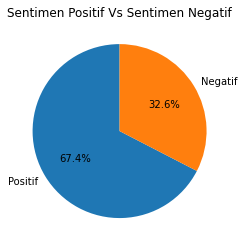

In [39]:
plt.pie(data,
       labels=['Positif', 'Negatif'],
       autopct='%1.1f%%',
       startangle=90)
plt.title('Sentimen Positif Vs Sentimen Negatif')
plt.show()

**2. Kata-kata yang paling sering muncul pada setiap sentimen**

In [40]:
df_positif = df[df['sentimen']==1]
df_positif

clean_text   positif   negatif  \
3    jakarta choky andriano angkat bicara kait tudi...  0.107955  0.073864   
7    kendal polres kendal jawa posko pasar sehat po...  0.116279  0.037209   
10   jakarta wakil gubernur dki jakarta ahmad riza ...  0.143646  0.127072   
11   jakarta satgas covid sorot covid pulau jawa ba...  0.164557  0.069620   
15   batu ribu pegawai hotel kota batu paksa rumah ...  0.100418  0.087866   
..                                                 ...       ...       ...   
704  jakarta panglima tni marsekal had tjahjanto ta...  0.058065  0.045161   
705  jakarta ketua asosiasi pusat belanja indonesia...  0.104895  0.020979   
706  jakarta satgas tangan covid perintah provinsi ...  0.135593  0.072034   
707  surabaya ketua dprd jatim kusnadi sorot putus ...  0.088083  0.067358   
708  jakarta perintah putus ppkm darurat terap leve...  0.146739  0.043478   

     sentimen  
3           1  
7           1  
10          1  
11          1  
15          1  
..        ...  
704         1  
705         1  
706         1  
707         1  
708         1  

[478 rows x 4 columns]

In [41]:
teks_data = df_positif['clean_text']
teks_data

3      jakarta choky andriano angkat bicara kait tudi...
7      kendal polres kendal jawa posko pasar sehat po...
10     jakarta wakil gubernur dki jakarta ahmad riza ...
11     jakarta satgas covid sorot covid pulau jawa ba...
15     batu ribu pegawai hotel kota batu paksa rumah ...
                             ...                        
704    jakarta panglima tni marsekal had tjahjanto ta...
705    jakarta ketua asosiasi pusat belanja indonesia...
706    jakarta satgas tangan covid perintah provinsi ...
707    surabaya ketua dprd jatim kusnadi sorot putus ...
708    jakarta perintah putus ppkm darurat terap leve...
Name: clean_text, Length: 478, dtype: object

In [42]:
token=[]
for teks in teks_data:
    token1=teks.split()
    token=token+token1
print(len(token))
teks_data_token=token

100815


In [43]:
word_list = token

counts = Counter(word_list)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]
indSort = indSort[0:10]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

In [44]:
labels

array(['ppkm', 'level', 'kabupaten', 'laku', 'covid', 'masyarakat',
       'baca', 'perintah', 'kota', 'bantu'], dtype='<U25')

In [45]:
values

array([2712, 1588, 1365, 1247, 1230,  939,  890,  805,  781,  741])

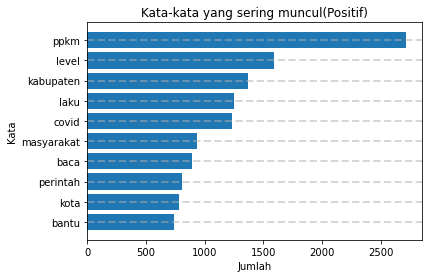

In [46]:
# Bar Plot antara jumlah kata(sb x) dan label kata(sb y)
plt.barh(labels[::-1], values[::-1])
# Menambahkan Grid
plt.grid(linestyle='--',
         linewidth=2,
         axis='y', #pilihan = x, y, both
         alpha=0.5)
# Menambahkan judul gambar
plt.title('Kata-kata yang sering muncul(Positif)')
# Menambahkan label pada sumbu x
plt.xlabel('Jumlah')
# Menambahkan label pada sumbu y
plt.ylabel('Kata')
# Menampilkan Gambar
plt.show()

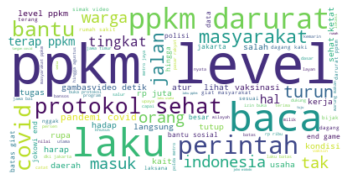

In [47]:
teks=' '.join(teks_data)
wordcloud = WordCloud(max_font_size=1000, max_words=100, background_color="white").generate(teks)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [48]:
df_negatif = df[df['sentimen']==0]
df_negatif

clean_text   positif   negatif  \
0    bekas seleb tiktok juyy putri urus hukum gelar...  0.022599  0.163842   
1    jakarta pandemi virus corona covid langsung in...  0.093333  0.133333   
2    bandung gubernur jawa barat ridwan kamil buka ...  0.083333  0.166667   
4    bekas satpol pp kota bekas menindaklanjuti inf...  0.017045  0.142045   
5    surabaya orang spekulan tabung oksigen surabay...  0.091398  0.096774   
..                                                 ...       ...       ...   
681  jakarta selebgram gebby vesta barubaru heboh b...  0.046243  0.092486   
682  palembang polisi tangkap oknum tugas honorer s...  0.050314  0.094340   
684  jakarta perintah ubah istilah ppkm darurat ppk...  0.000000  0.090909   
690  jakarta artis anggota dprd tina toon sanksi pi...  0.079365  0.089947   
693  jakarta pos sekat ppkm pria bengkulu masker da...  0.044715  0.101626   

     sentimen  
0           0  
1           0  
2           0  
4           0  
5           0  
..        ...  
681         0  
682         0  
684         0  
690         0  
693         0  

[231 rows x 4 columns]

In [49]:
teks_data = df_negatif['clean_text']
teks_data

0      bekas seleb tiktok juyy putri urus hukum gelar...
1      jakarta pandemi virus corona covid langsung in...
2      bandung gubernur jawa barat ridwan kamil buka ...
4      bekas satpol pp kota bekas menindaklanjuti inf...
5      surabaya orang spekulan tabung oksigen surabay...
                             ...                        
681    jakarta selebgram gebby vesta barubaru heboh b...
682    palembang polisi tangkap oknum tugas honorer s...
684    jakarta perintah ubah istilah ppkm darurat ppk...
690    jakarta artis anggota dprd tina toon sanksi pi...
693    jakarta pos sekat ppkm pria bengkulu masker da...
Name: clean_text, Length: 231, dtype: object

In [50]:
token=[]
for teks in teks_data:
    token1=teks.split()
    token=token+token1
print(len(token))
teks_data_token=token

45412


In [51]:
word_list = token

counts = Counter(word_list)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]
indSort = indSort[0:10]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

In [52]:
labels

array(['ppkm', 'laku', 'covid', 'level', 'baca', 'makan', 'jalan', 'atur',
       'orang', 'jakarta'], dtype='<U23')

In [53]:
values

array([1039,  537,  535,  524,  428,  381,  334,  313,  290,  265])

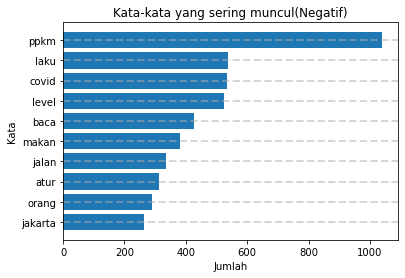

In [54]:
# Bar Plot antara jumlah kata(sb x) dan label kata(sb y)
plt.barh(labels[::-1], values[::-1])
# Menambahkan Grid
plt.grid(linestyle='--',
         linewidth=2,
         axis='y', #pilihan = x, y, both
         alpha=0.5)
# Menambahkan judul gambar
plt.title('Kata-kata yang sering muncul(Negatif)')
# Menambahkan label pada sumbu x
plt.xlabel('Jumlah')
# Menambahkan label pada sumbu y
plt.ylabel('Kata')
# Menampilkan Gambar
plt.show()

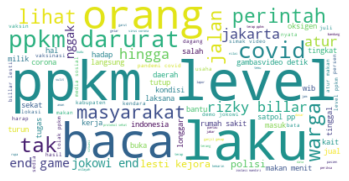

In [55]:
teks=' '.join(teks_data)
wordcloud = WordCloud(max_font_size=1000, max_words=100, background_color="white").generate(teks)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()